# Installs & Imports

In [1]:
!pip install -q xgboost lightgbm catboost pytorch_tabular feature-engine ucimlrepo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import joblib
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import TabNetModelConfig, TabTransformerConfig, NodeConfig, GANDALFConfig

from ucimlrepo import fetch_ucirepo

from feature_engine.creation import RelativeFeatures

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data

In [3]:
# Load the dataset
wine_ds = fetch_ucirepo(id=186)

In [4]:
# Extract features and labels
X = wine_ds.data.features
y = wine_ds.data.targets

In [5]:
# Create single DataFrame
df = pd.concat([X, y], axis=1)

In [6]:
# Examine the DataFrame
df.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [7]:
# Examine the shape
print(f"There are {df.shape[0]} rows")
print(f"There are {df.shape[1]} columns")

There are 6497 rows
There are 12 columns


# Exploring the Data

In [8]:
# Get quick information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [9]:
# Value counts of the label
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [10]:
# Descriptive statistics
df.describe().round(2).T

count    mean    std   min    25%     50%     75%  \
fixed_acidity         6497.0    7.22   1.30  3.80   6.40    7.00    7.70   
volatile_acidity      6497.0    0.34   0.16  0.08   0.23    0.29    0.40   
citric_acid           6497.0    0.32   0.15  0.00   0.25    0.31    0.39   
residual_sugar        6497.0    5.44   4.76  0.60   1.80    3.00    8.10   
chlorides             6497.0    0.06   0.04  0.01   0.04    0.05    0.06   
free_sulfur_dioxide   6497.0   30.53  17.75  1.00  17.00   29.00   41.00   
total_sulfur_dioxide  6497.0  115.74  56.52  6.00  77.00  118.00  156.00   
density               6497.0    0.99   0.00  0.99   0.99    0.99    1.00   
pH                    6497.0    3.22   0.16  2.72   3.11    3.21    3.32   
sulphates             6497.0    0.53   0.15  0.22   0.43    0.51    0.60   
alcohol               6497.0   10.49   1.19  8.00   9.50   10.30   11.30   
quality               6497.0    5.82   0.87  3.00   5.00    6.00    6.00   

                         max  
fixed_acidity          15.90  
volatile_acidity        1.58  
citric_acid             1.66  
residual_sugar         65.80  
chlorides               0.61  
free_sulfur_dioxide   289.00  
total_sulfur_dioxide  440.00  
density                 1.04  
pH                      4.01  
sulphates               2.00  
alcohol                14.90  
quality                 9.00

In [11]:
# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Statistics by quality
df.groupby('quality').describe().round(2)

fixed_acidity                                          \
                count  mean   std  min  25%   50%   75%   max   
quality                                                         
3                30.0  7.85  1.75  4.2  6.8  7.45  8.57  11.8   
4               216.0  7.29  1.26  4.6  6.4  7.00  8.00  12.5   
5              2138.0  7.33  1.26  4.5  6.5  7.10  7.80  15.9   
6              2836.0  7.18  1.29  3.8  6.4  6.90  7.60  14.3   
7              1079.0  7.13  1.37  4.2  6.3  6.90  7.40  15.6   
8               193.0  6.84  1.15  3.9  6.2  6.80  7.30  12.6   
9                 5.0  7.42  0.98  6.6  6.9  7.10  7.40   9.1   

        volatile_acidity                                            \
                   count  mean   std   min   25%   50%   75%   max   
quality                                                              
3                   30.0  0.52  0.34  0.17  0.25  0.42  0.63  1.58   
4                  216.0  0.46  0.23  0.11  0.28  0.38  0.61  1.13   
5                 2138.0  0.39  0.18  0.10  0.26  0.33  0.49  1.33   
6                 2836.0  0.31  0.15  0.08  0.21  0.27  0.37  1.04   
7                 1079.0  0.29  0.12  0.08  0.20  0.27  0.34  0.92   
8                  193.0  0.29  0.12  0.12  0.20  0.28  0.35  0.85   
9                    5.0  0.30  0.06  0.24  0.26  0.27  0.36  0.36   

        citric_acid                                           residual_sugar  \
              count  mean   std   min   25%   50%   75%   max          count   
quality                                                                        
3              30.0  0.28  0.17  0.00  0.21  0.33  0.40  0.66           30.0   
4             216.0  0.27  0.18  0.00  0.14  0.26  0.37  1.00          216.0   
5            2138.0  0.31  0.16  0.00  0.21  0.30  0.40  1.00         2138.0   
6            2836.0  0.32  0.14  0.00  0.26  0.31  0.39  1.66         2836.0   
7            1079.0  0.33  0.11  0.00  0.28  0.32  0.39  0.76         1079.0   
8             193.0  0.33  0.10  0.03  0.28  0.32  0.36  0.74          193.0   
9               5.0  0.39  0.08  0.29  0.34  0.36  0.45  0.49            5.0   

                                                  chlorides                    \
         mean   std  min   25%   50%   75%    max     count  mean   std   min   
quality                                                                         
3        5.14  4.73  0.7  1.65  3.15  7.80  16.20      30.0  0.08  0.06  0.02   
4        4.15  3.81  0.7  1.40  2.20  5.60  17.55     216.0  0.06  0.05  0.01   
5        5.80  4.99  0.6  1.80  3.00  8.75  23.50    2138.0  0.06  0.04  0.01   
6        5.55  4.89  0.7  1.80  3.10  8.30  65.80    2836.0  0.05  0.03  0.02   
7        4.73  4.04  0.9  1.80  2.80  6.30  19.25    1079.0  0.05  0.02  0.01   
8        5.38  4.18  0.8  2.00  4.10  7.60  14.80     193.0  0.04  0.02  0.01   
9        4.12  3.76  1.6  2.00  2.20  4.20  10.60       5.0  0.03  0.01  0.02   

                                free_sulfur_dioxide                      \
          25%   50%   75%   max               count   mean    std   min   
quality                                                                   
3        0.04  0.06  0.08  0.27                30.0  39.22  59.99   3.0   
4        0.04  0.05  0.07  0.61               216.0  20.64  18.87   3.0   
5        0.04  0.05  0.08  0.61              2138.0  30.24  18.57   2.0   
6        0.04  0.05  0.06  0.42              2836.0  31.17  16.84   1.0   
7        0.03  0.04  0.05  0.36              1079.0  30.42  14.93   3.0   
8        0.03  0.04  0.04  0.12               193.0  34.53  17.20   3.0   
9        0.02  0.03  0.03  0.04                 5.0  33.40  13.43  24.0   

                                   total_sulfur_dioxide                        \
           25%   50%    75%    max                count    mean     std   min   
quality                                                                         
3         5.25  17.0  37.38  289.0                

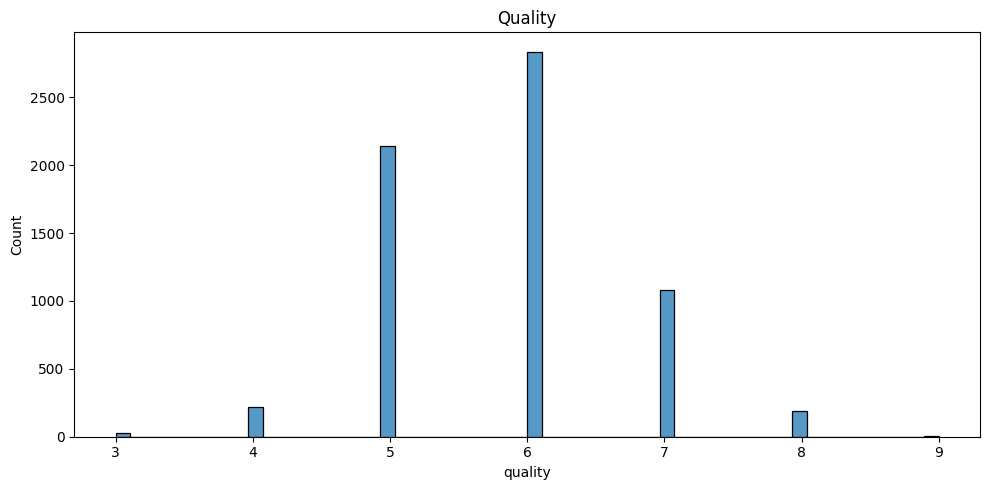

In [12]:
# Plot histogram for label
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='quality', ax=ax)
plt.title('Quality')
plt.tight_layout()
plt.show()

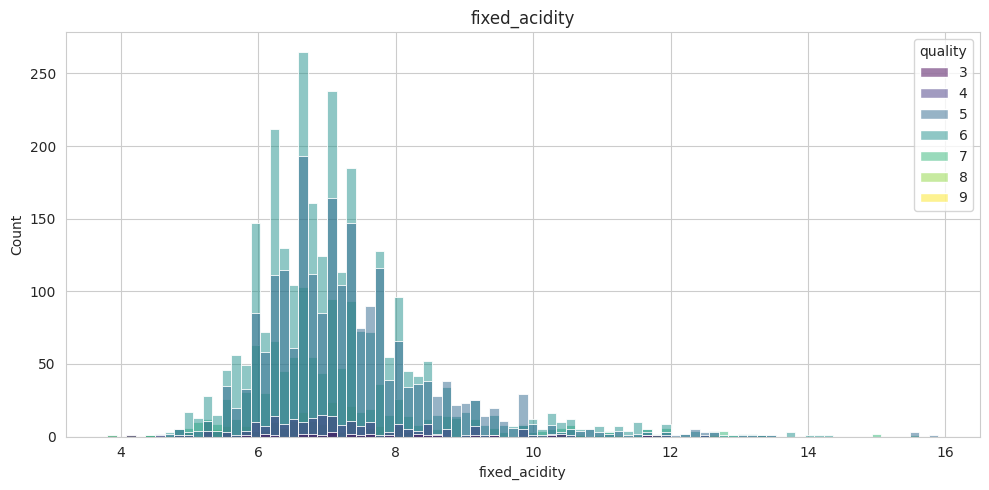

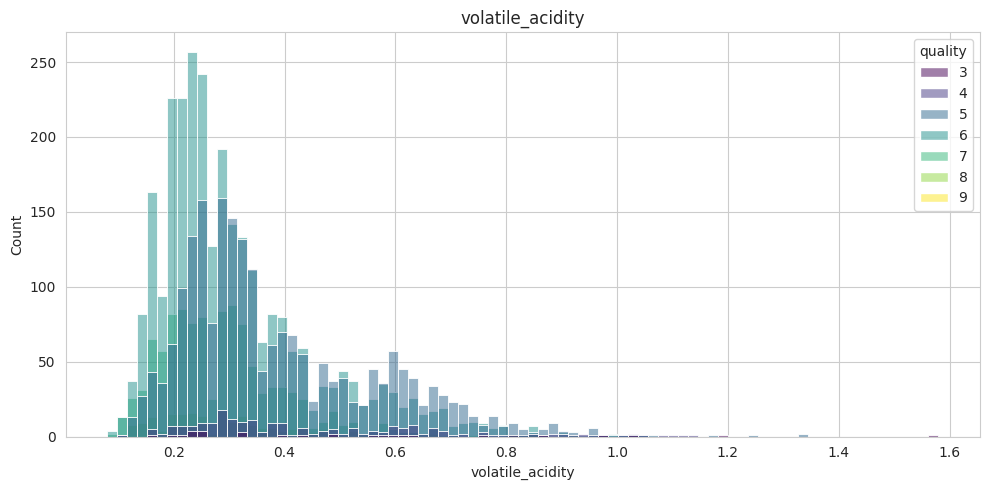

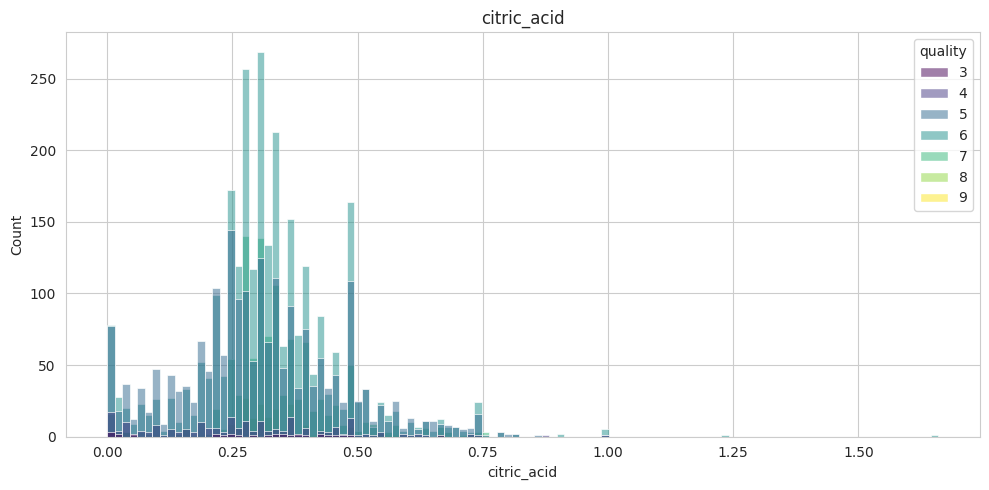

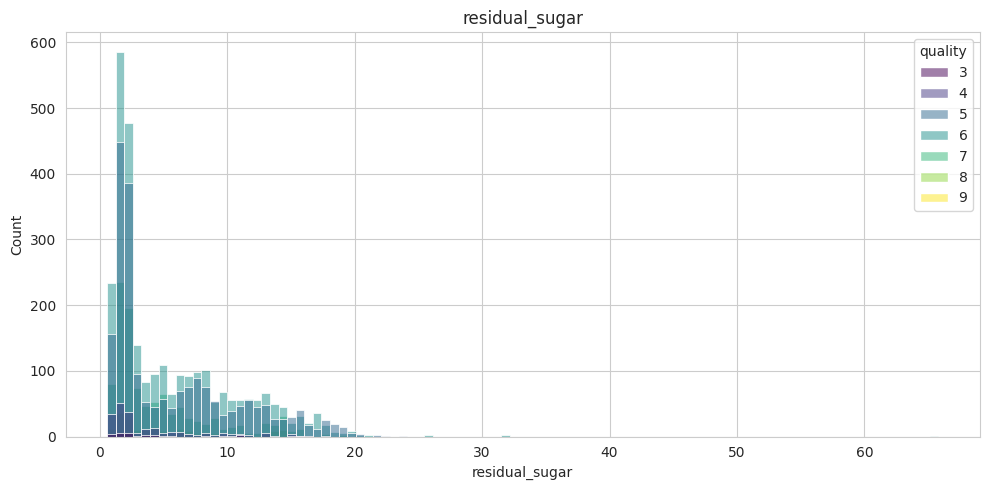

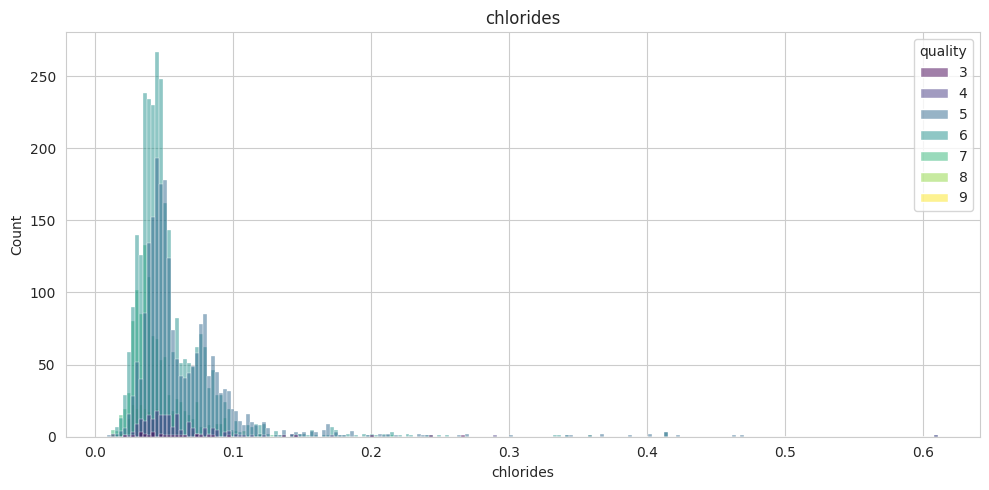

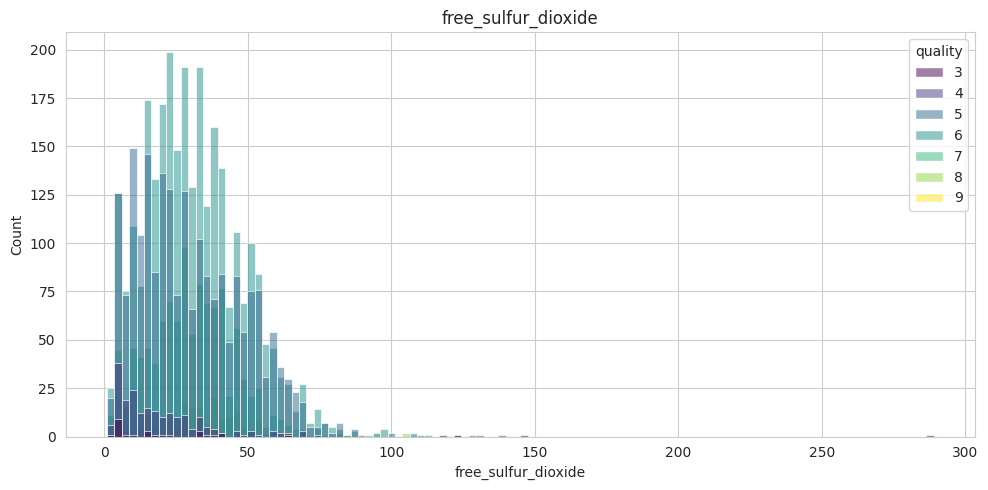

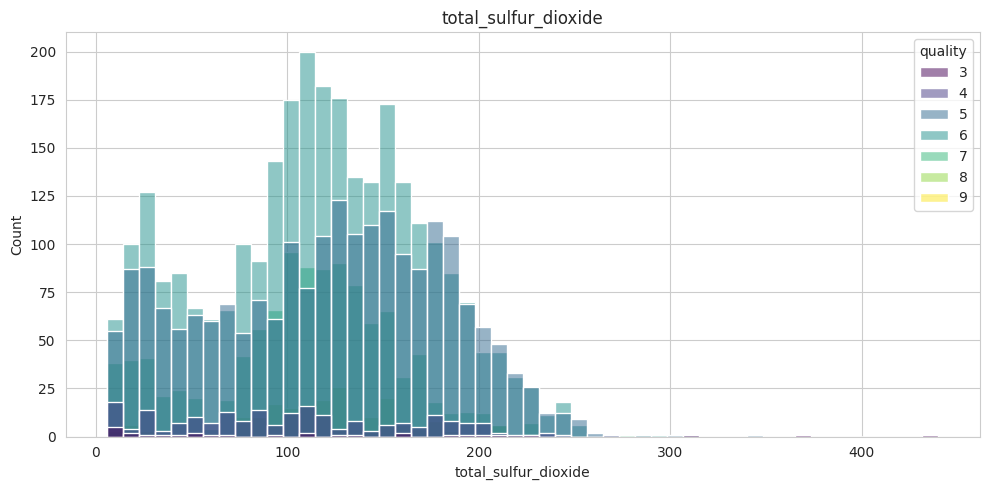

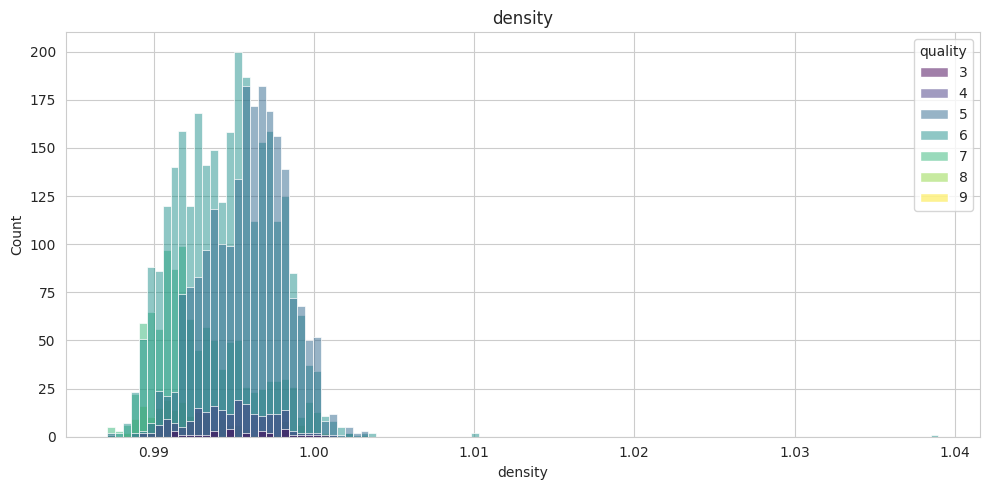

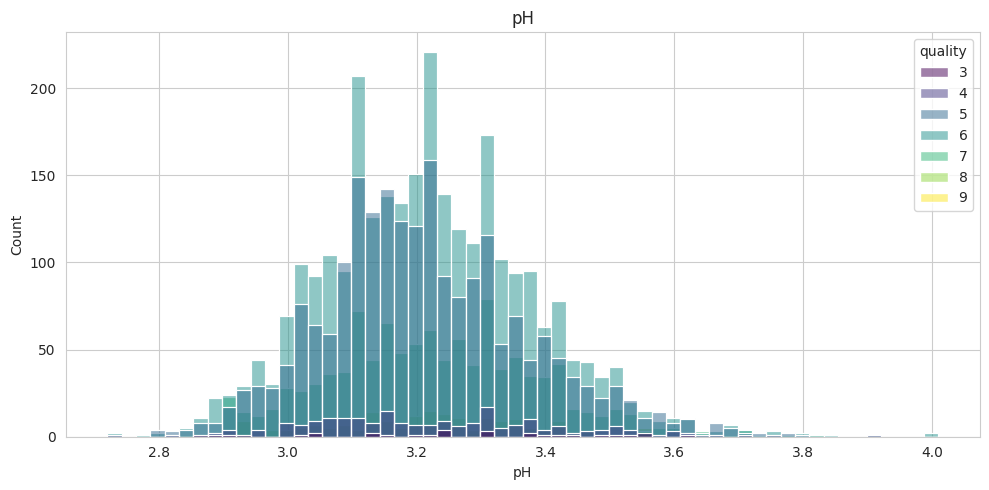

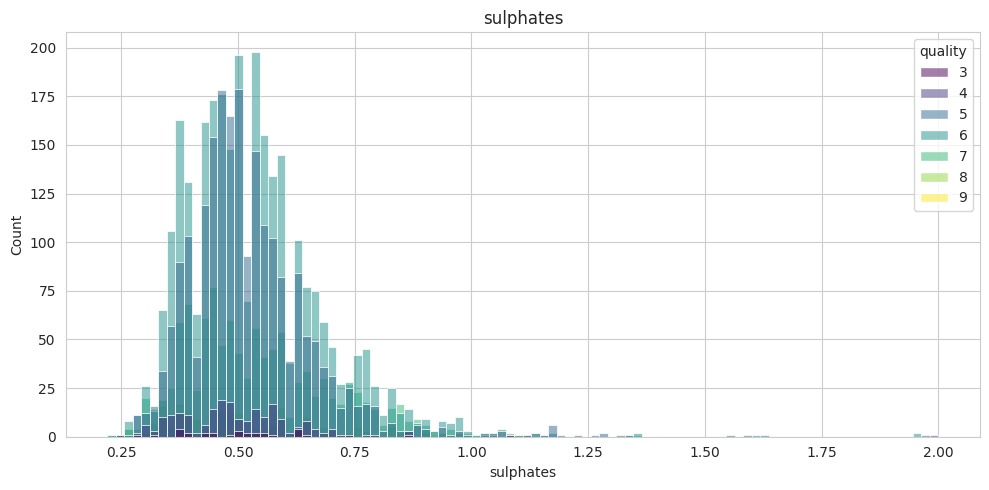

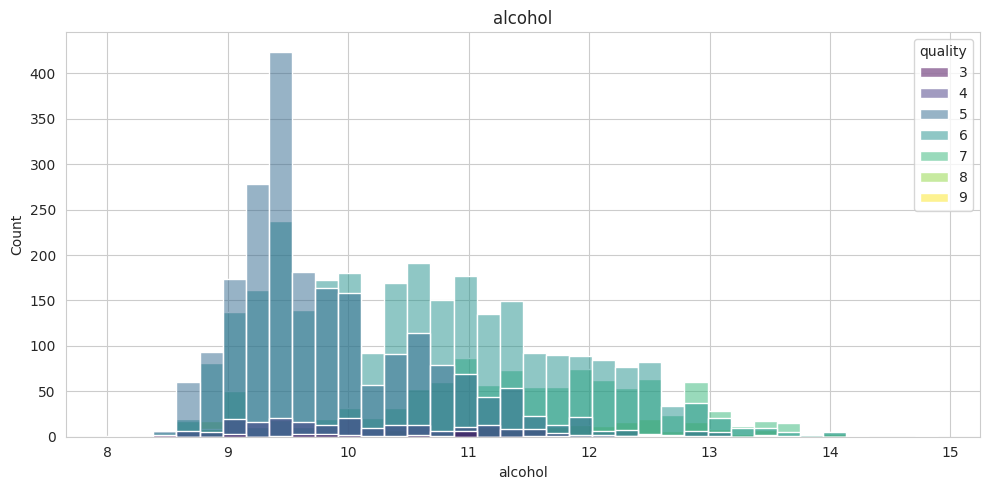

In [13]:
# Plot histogram for each feature
sns.set_style("whitegrid")

for col in [col for col in df.columns if col != 'quality']:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(data=df, x=col, hue='quality', palette='viridis', ax=ax)
    plt.title(col)
    plt.tight_layout()
    plt.show()

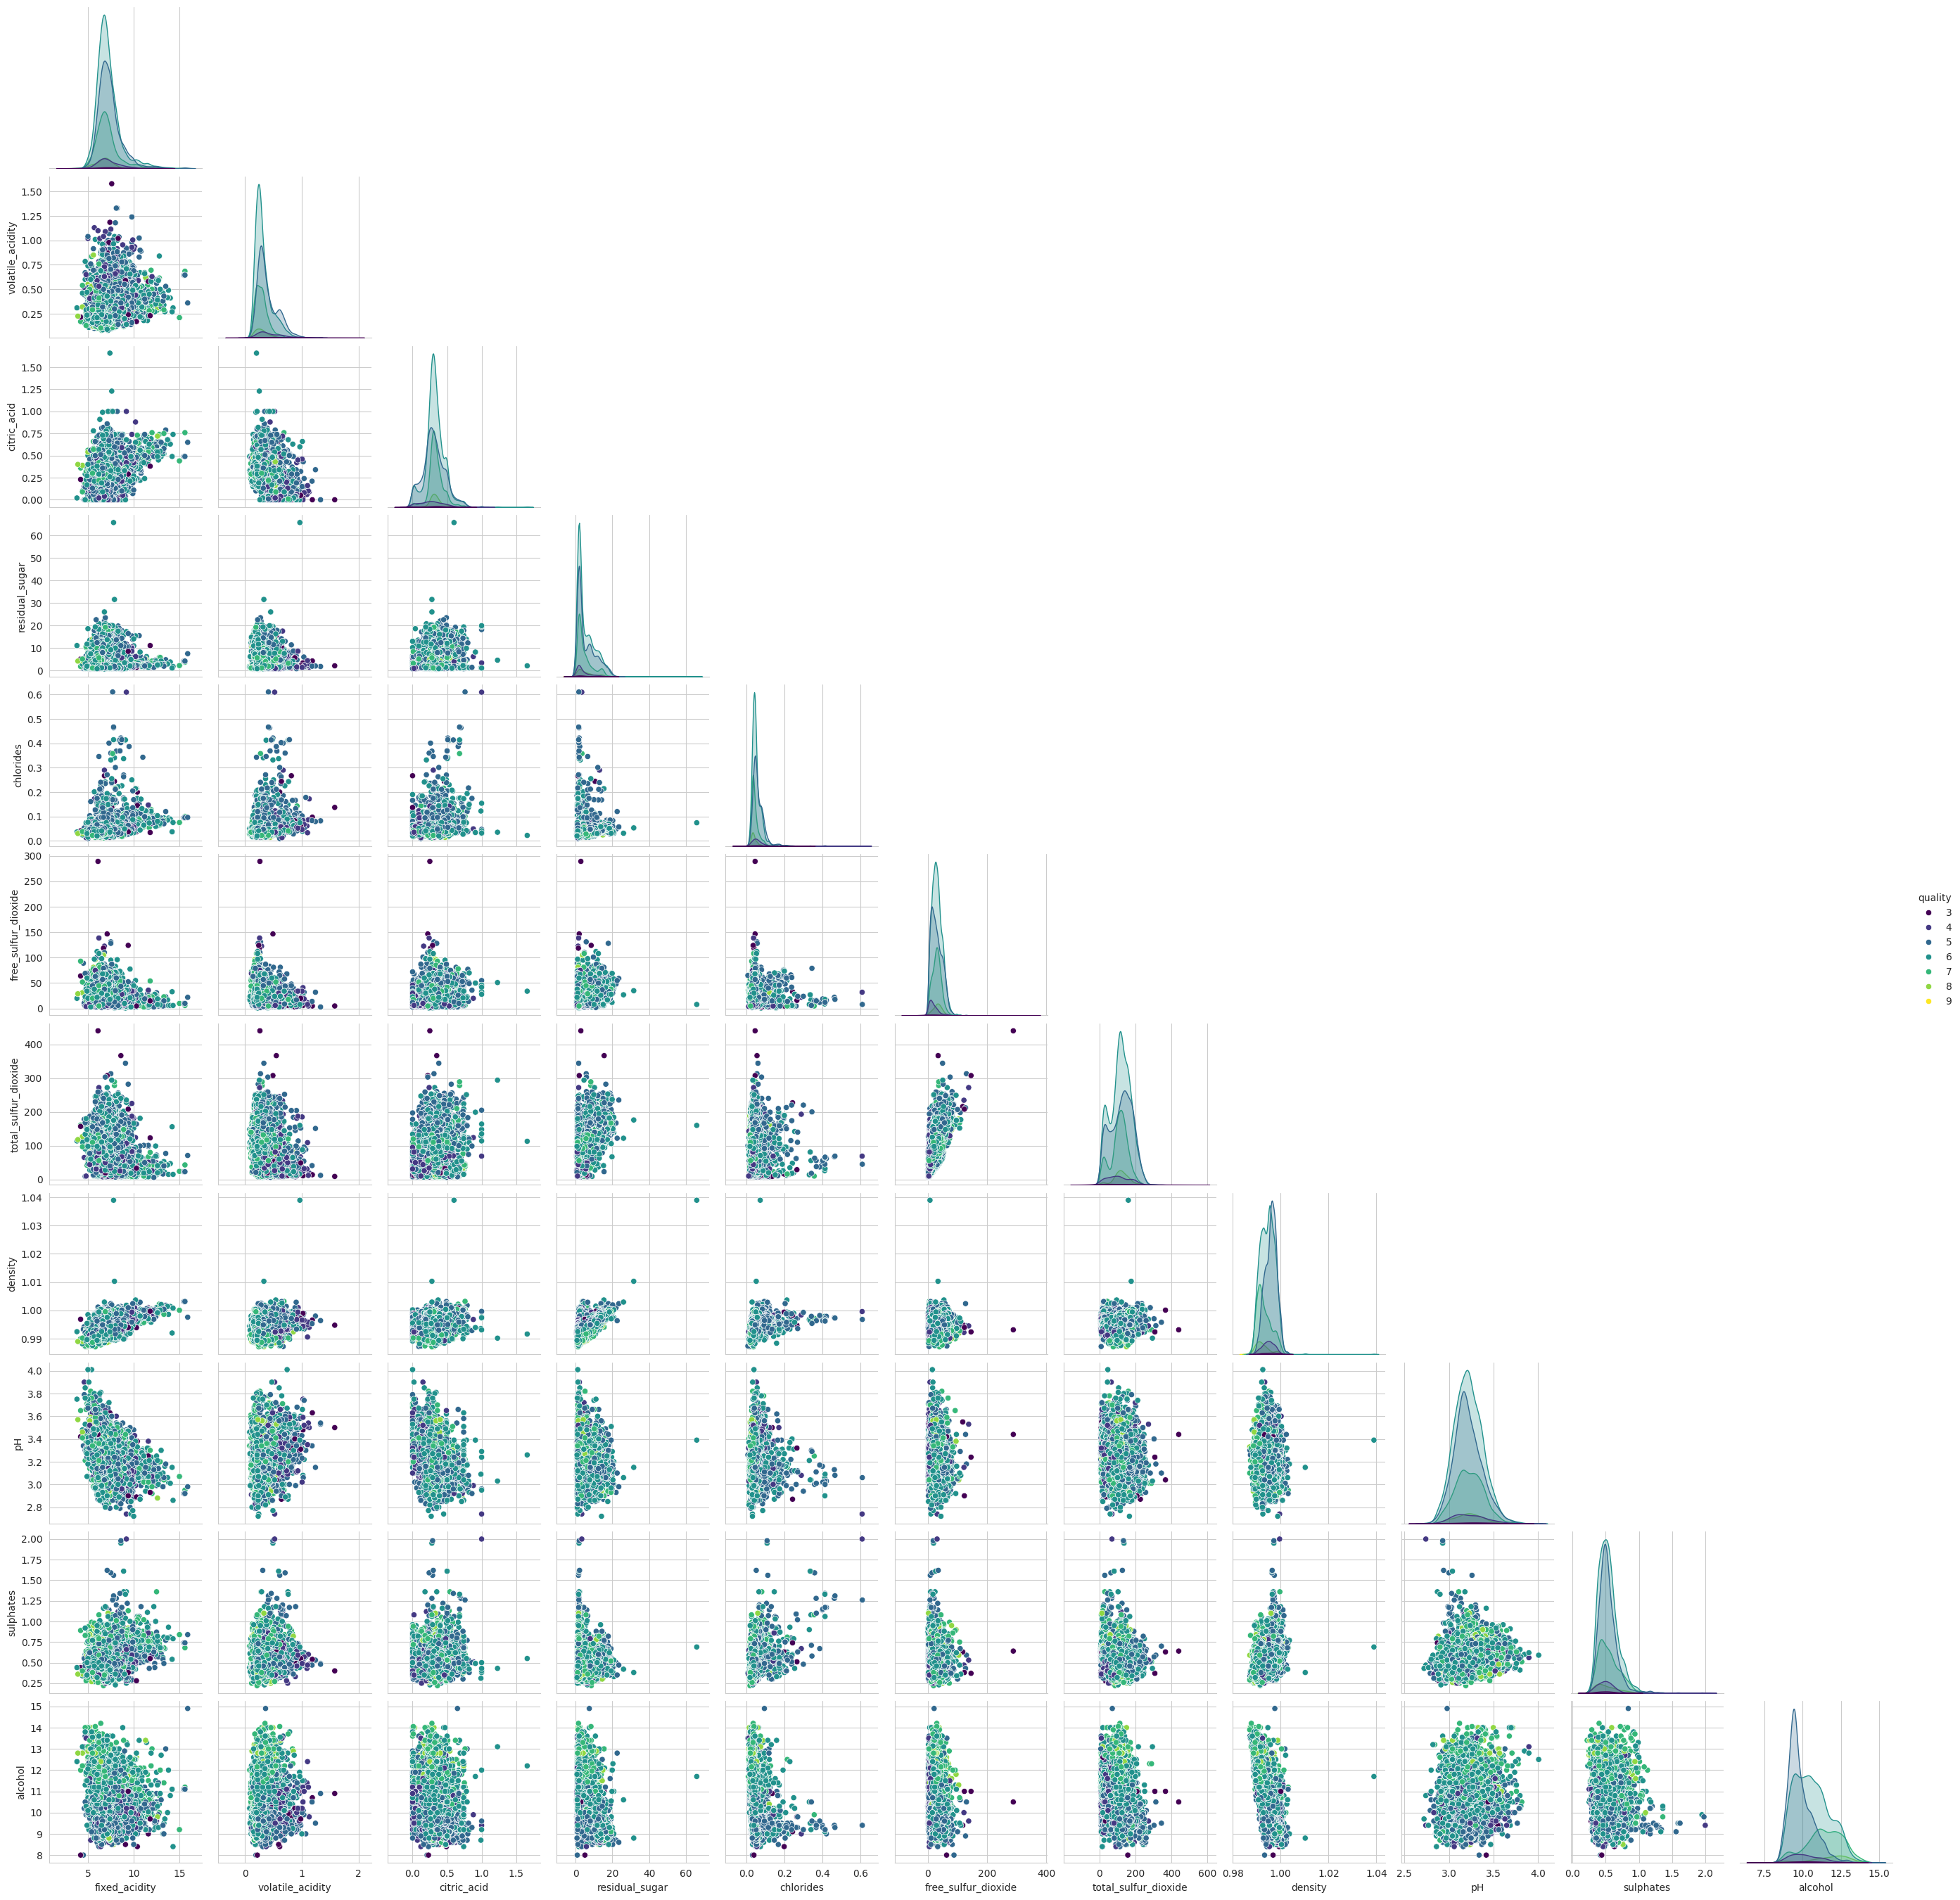

In [14]:
# Plot the pairplot
sns.pairplot(data=df, hue='quality', palette='viridis', corner=True)
plt.show()

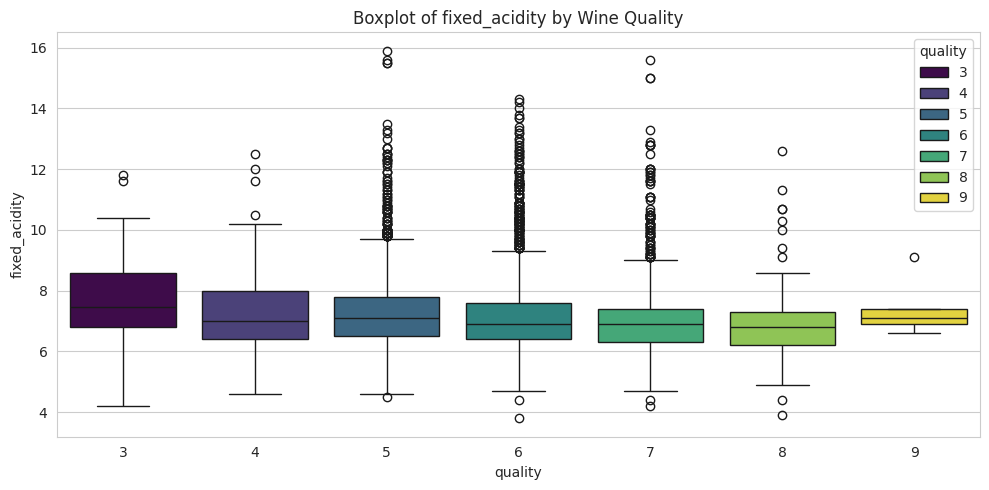

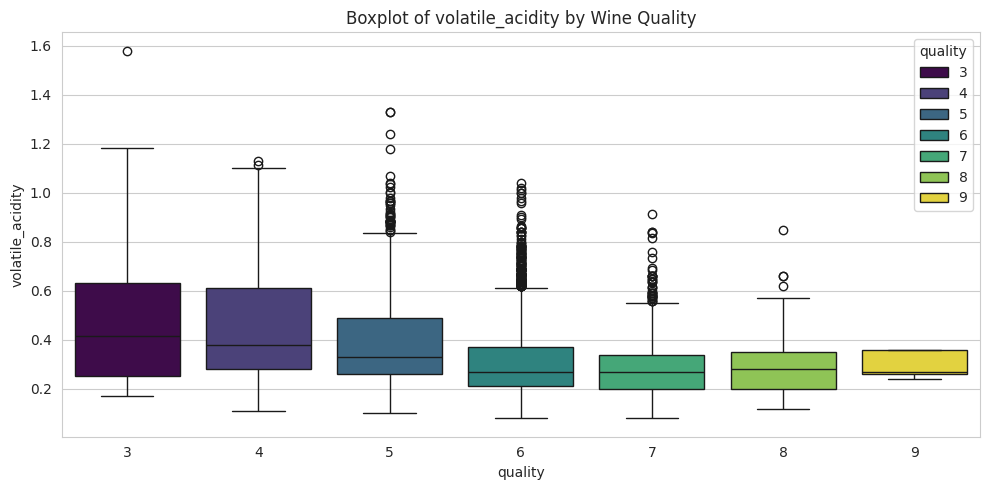

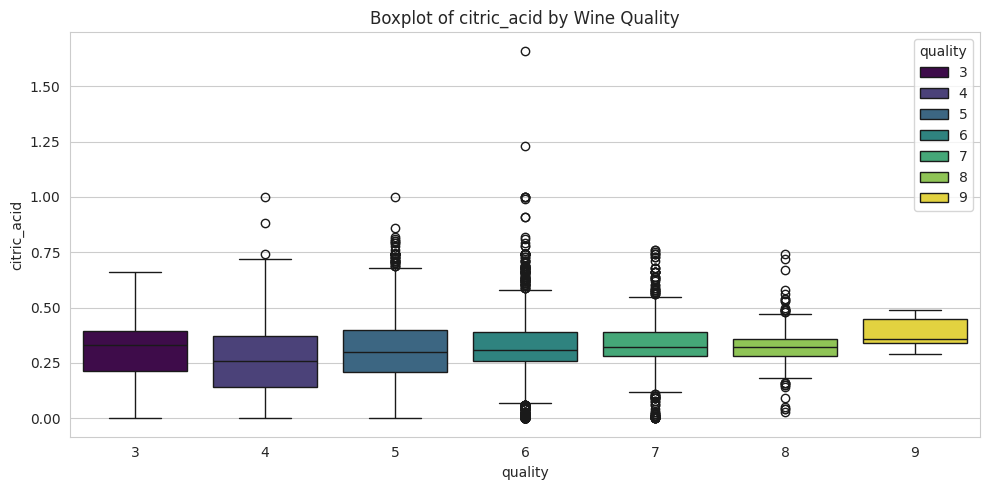

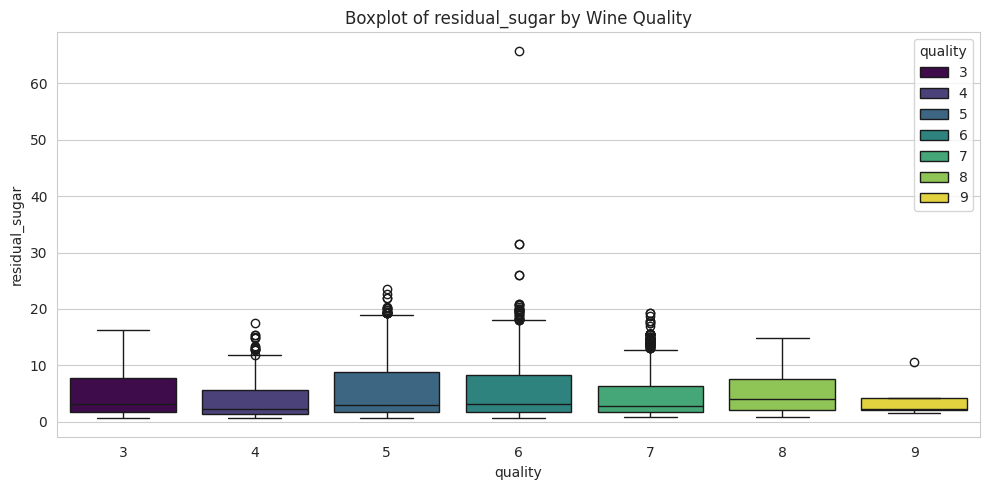

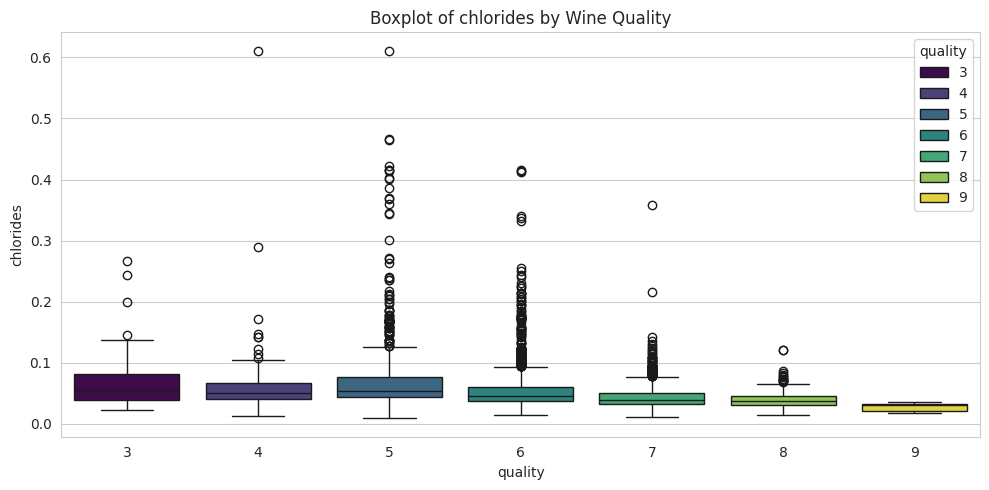

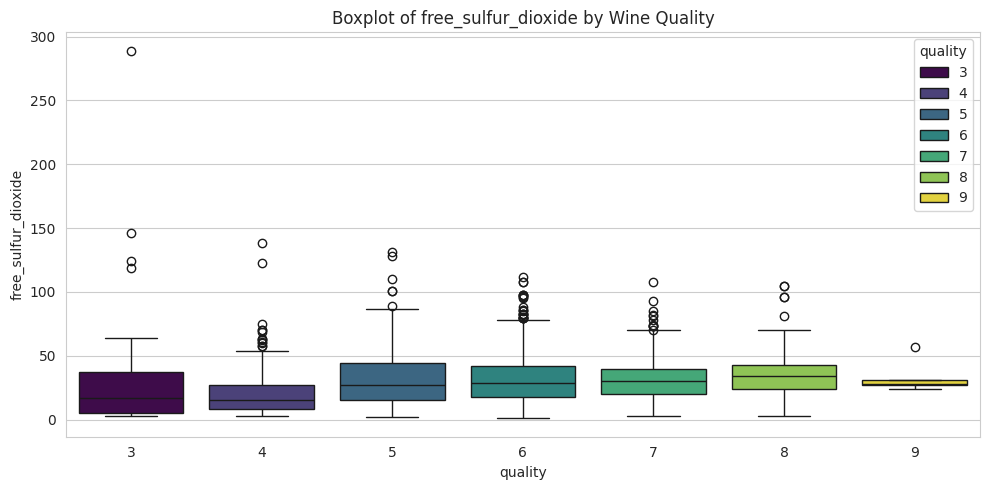

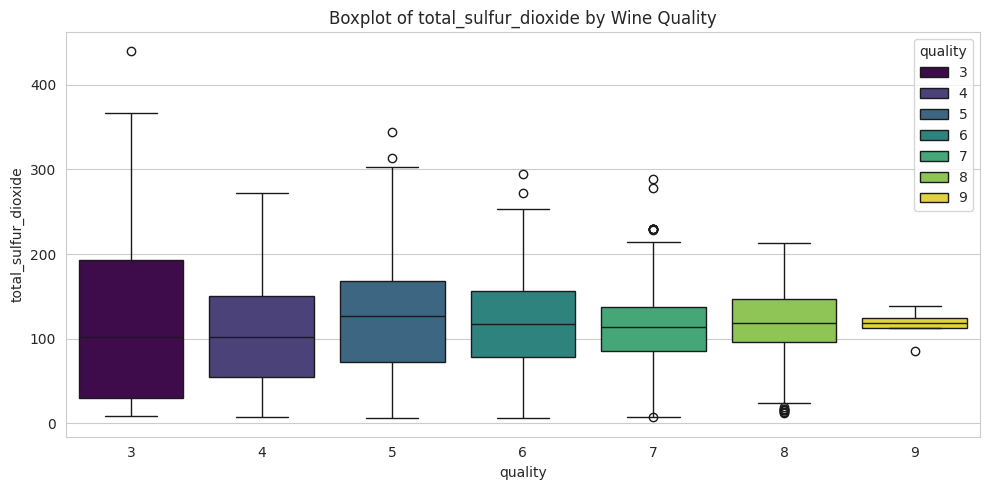

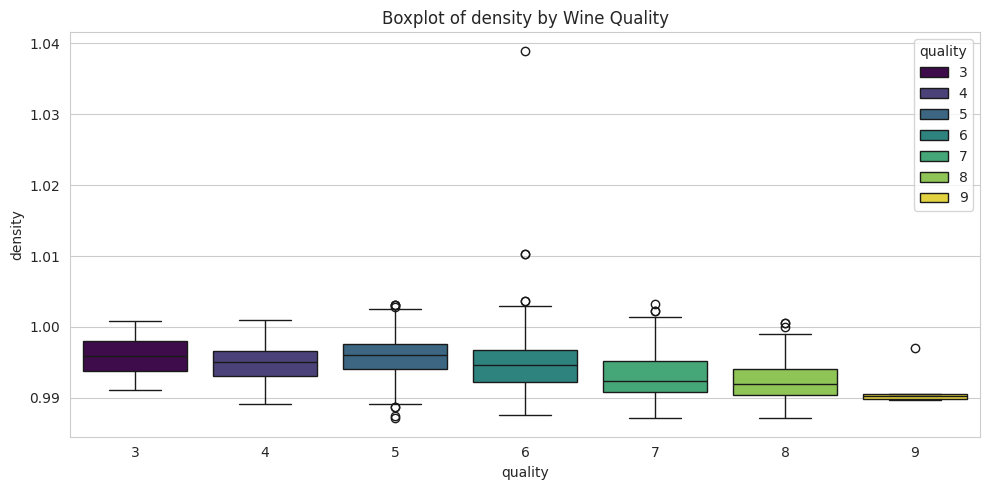

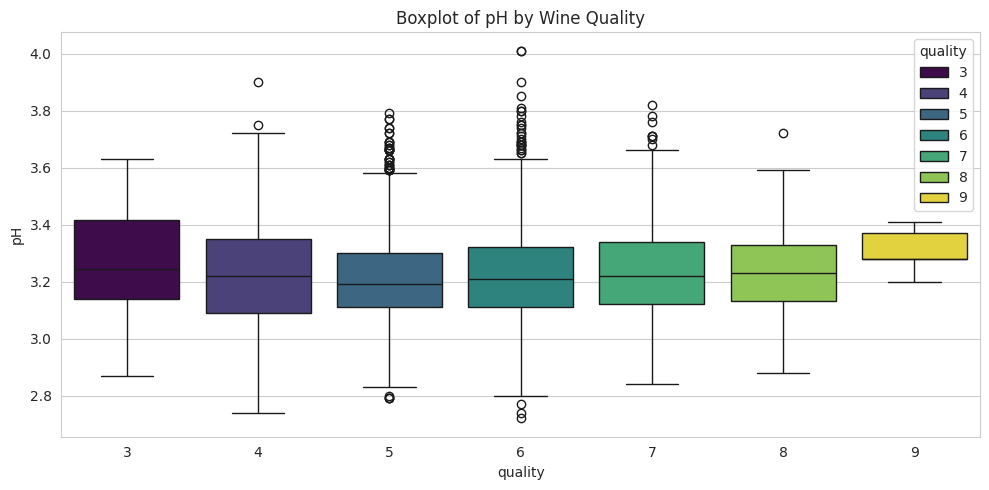

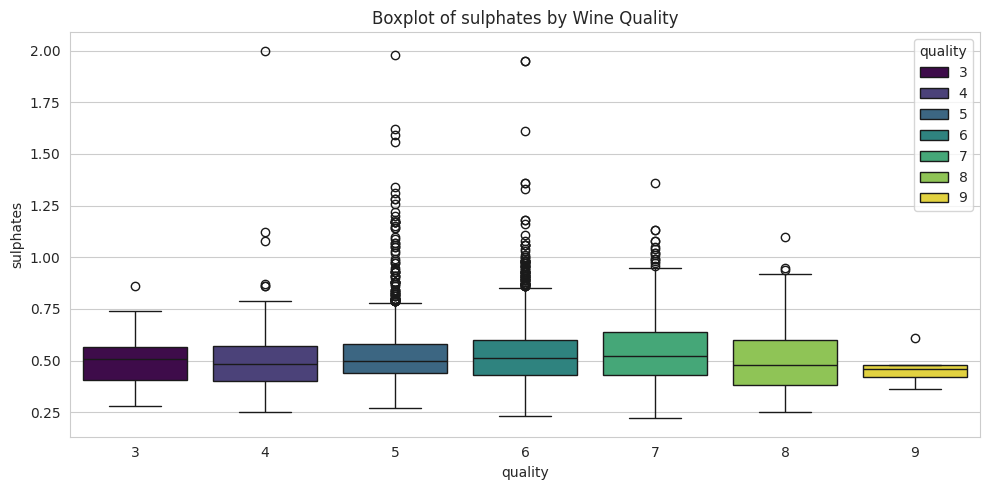

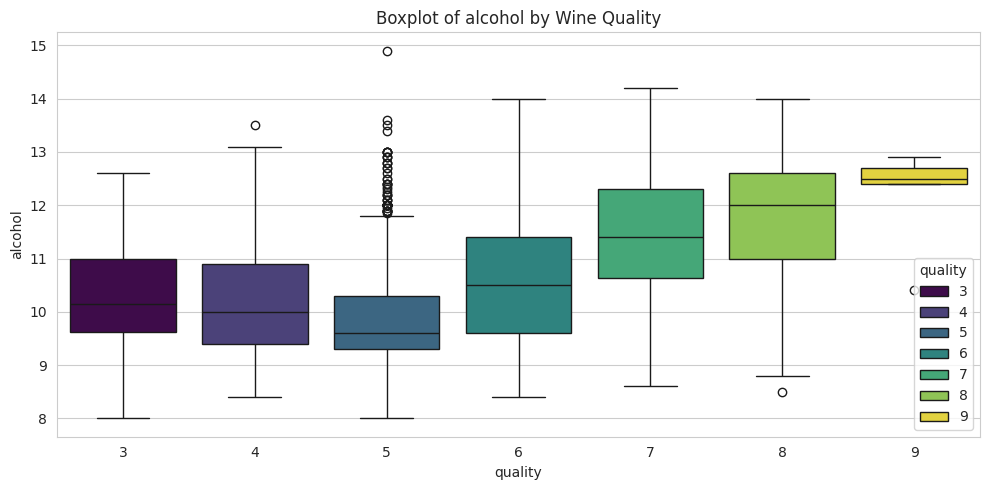

In [15]:
# Plot boxplot for each feature
for col in [col for col in df.columns if col != 'quality']:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df, x='quality', y=col, hue='quality', palette='viridis', ax=ax)
    plt.title(f'Boxplot of {col} by Wine Quality')
    plt.tight_layout()
    plt.show()

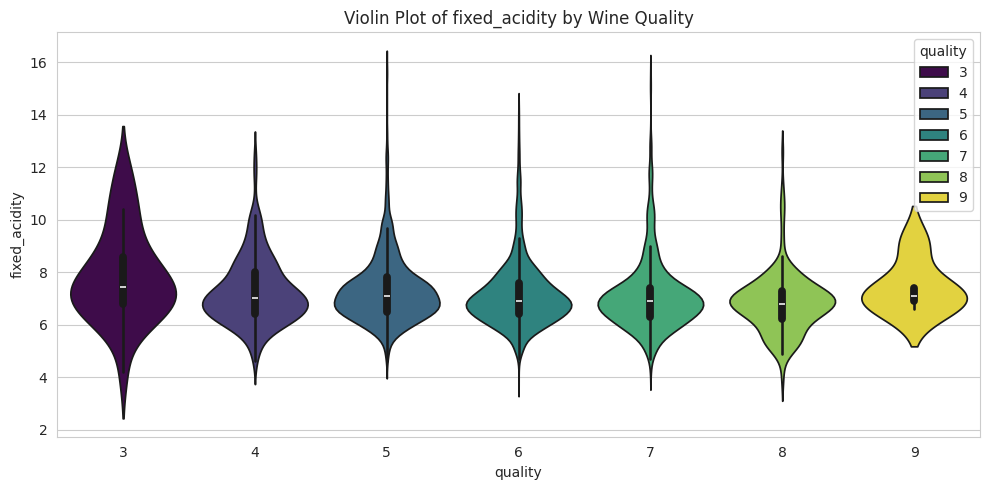

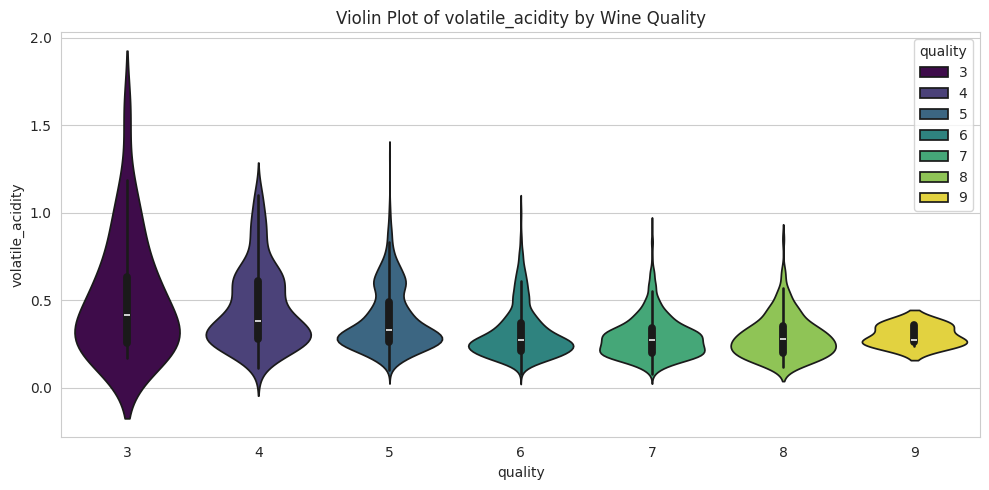

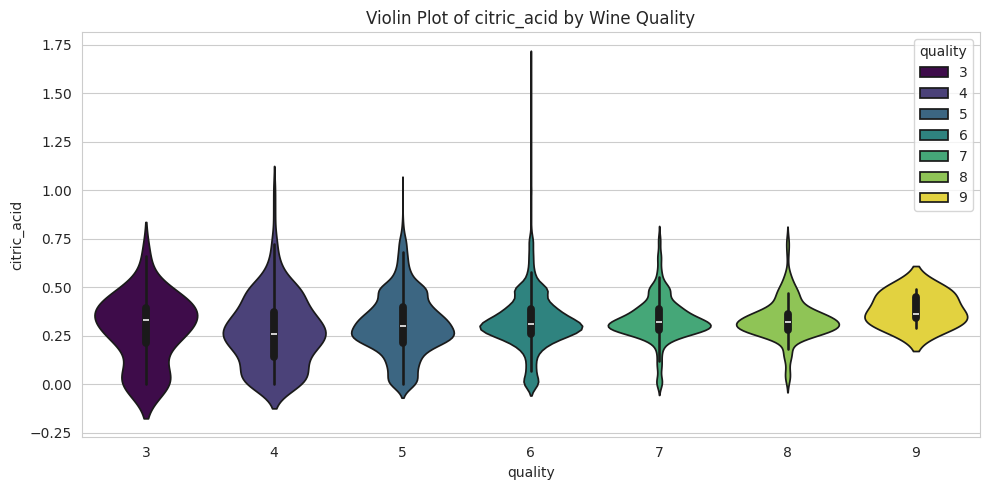

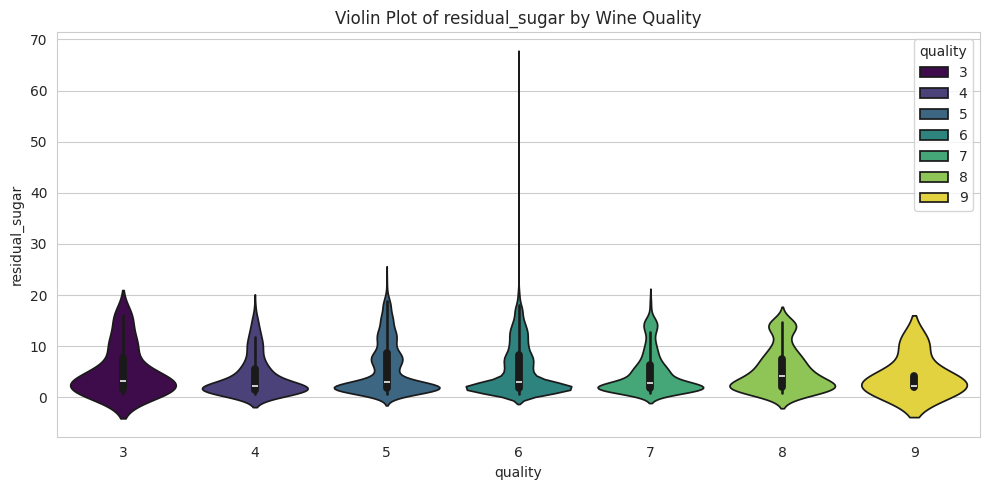

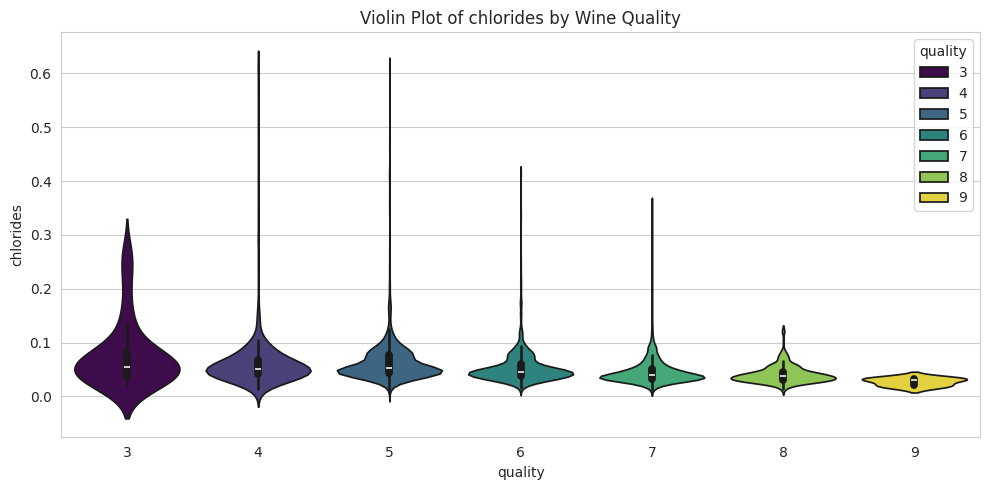

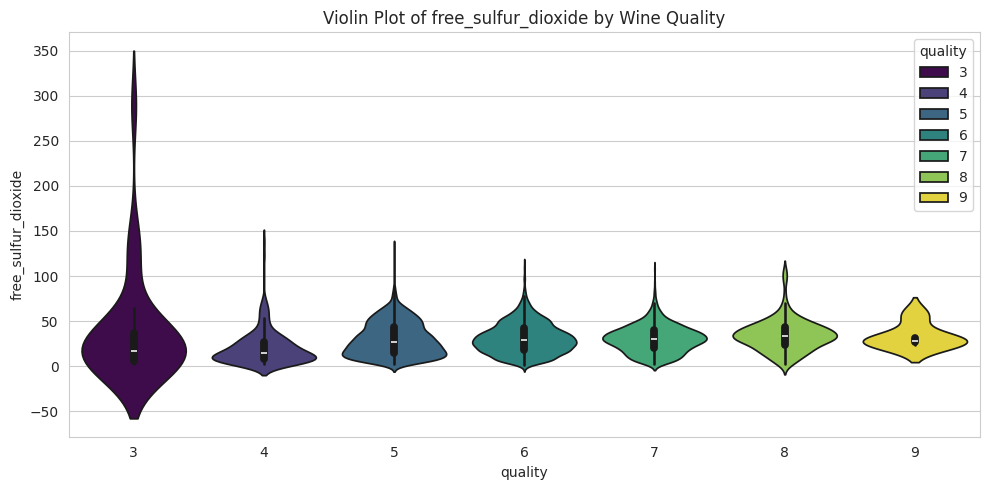

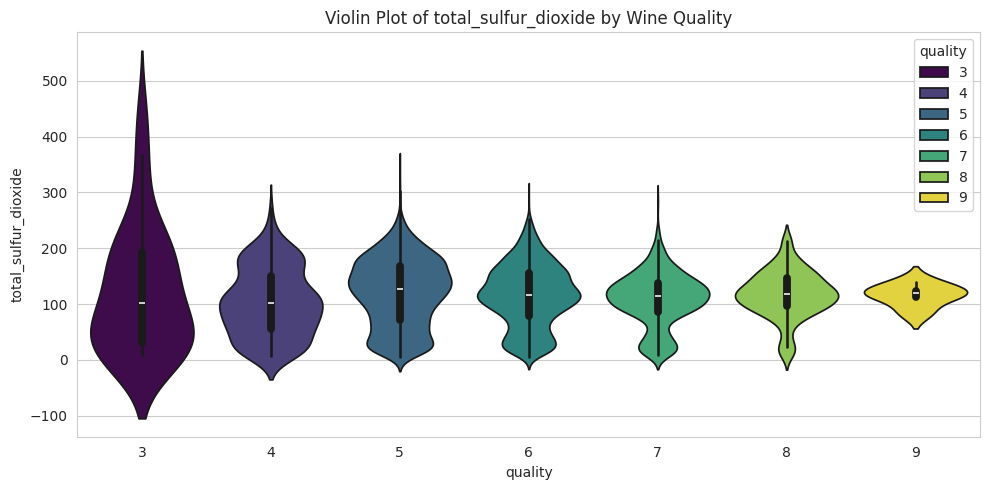

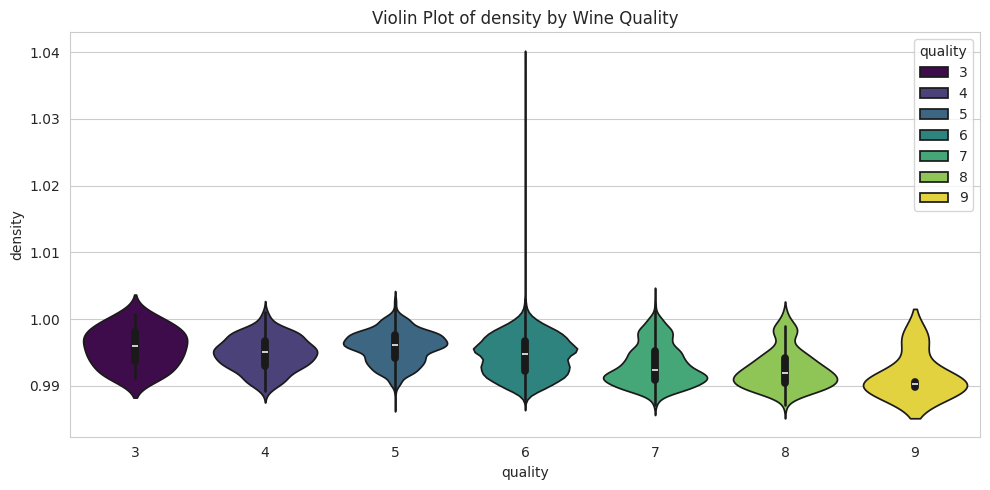

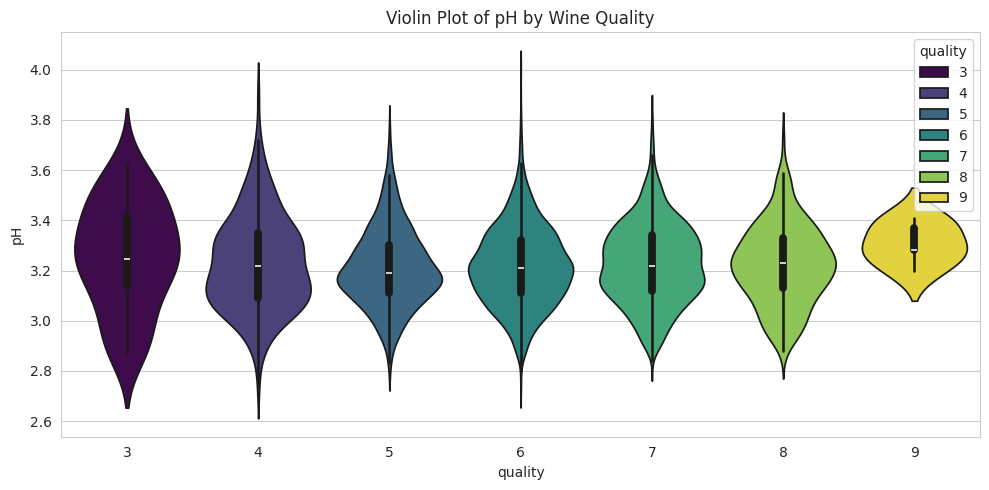

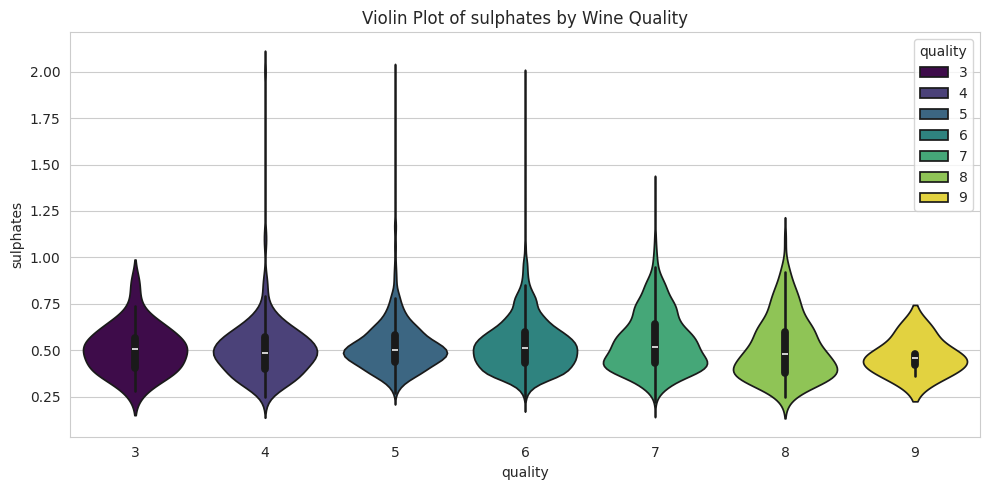

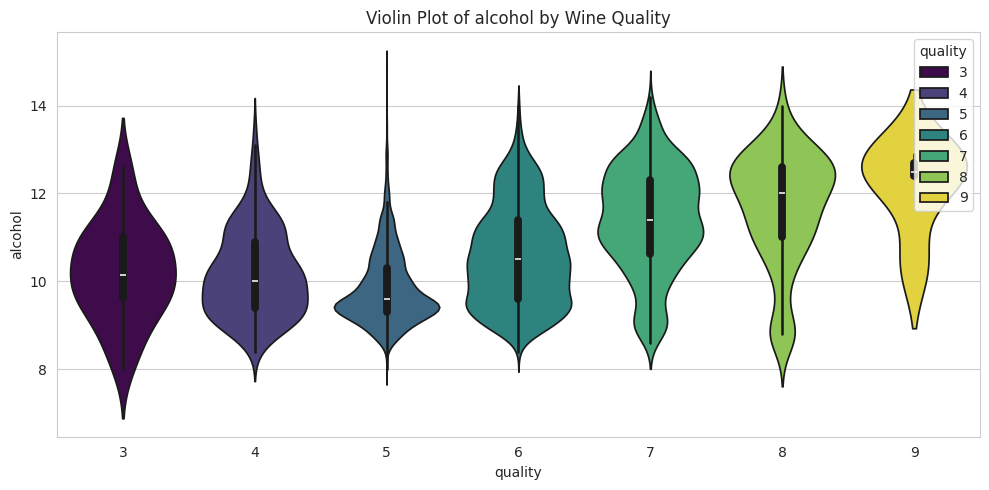

In [16]:
# Plot violin plot for each feature
for col in [col for col in df.columns if col != 'quality']:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.violinplot(data=df, x='quality', y=col, hue='quality', palette='viridis', ax=ax)
    plt.title(f'Violin Plot of {col} by Wine Quality')
    plt.tight_layout()
    plt.show()

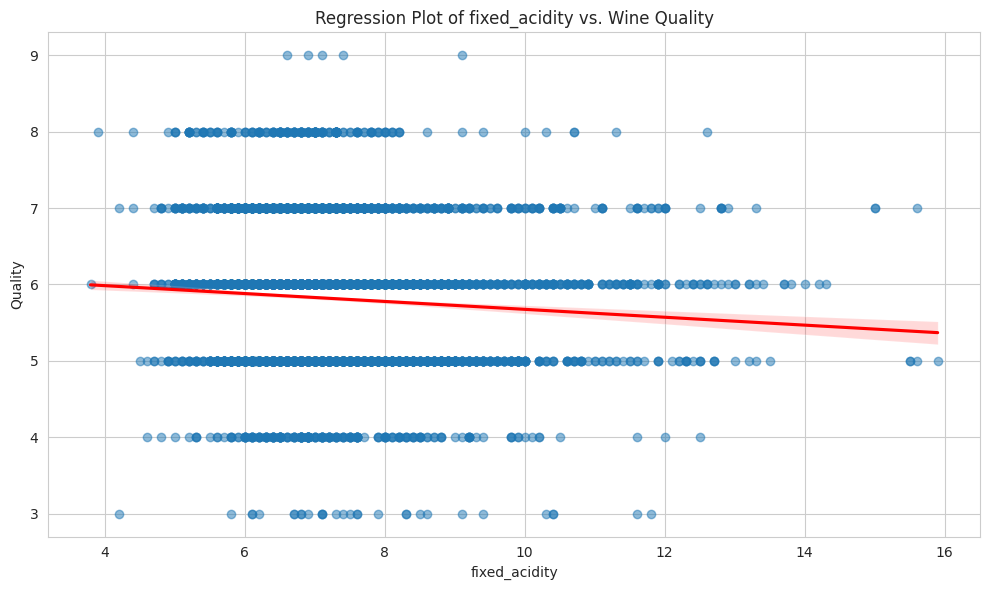

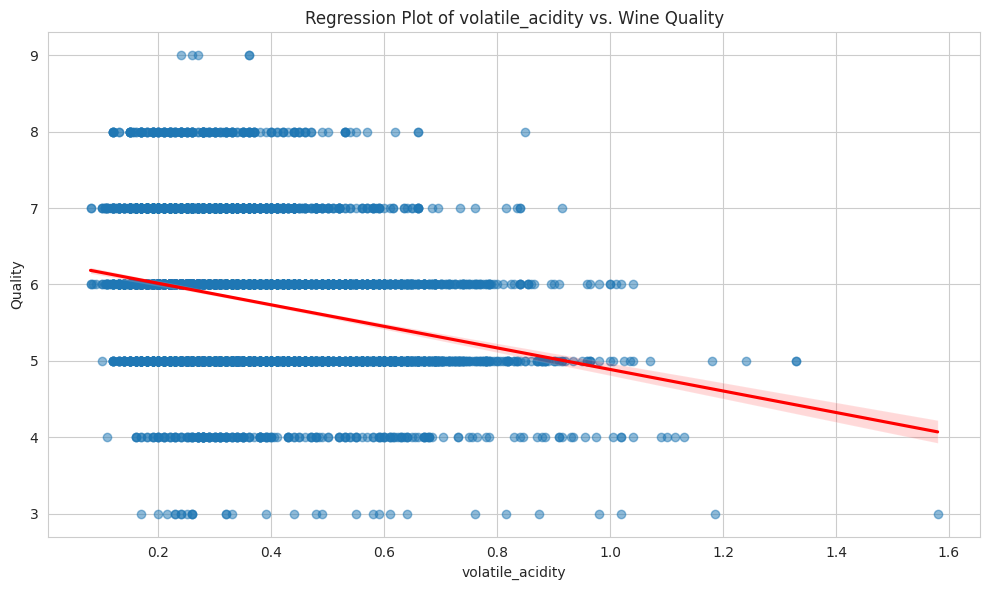

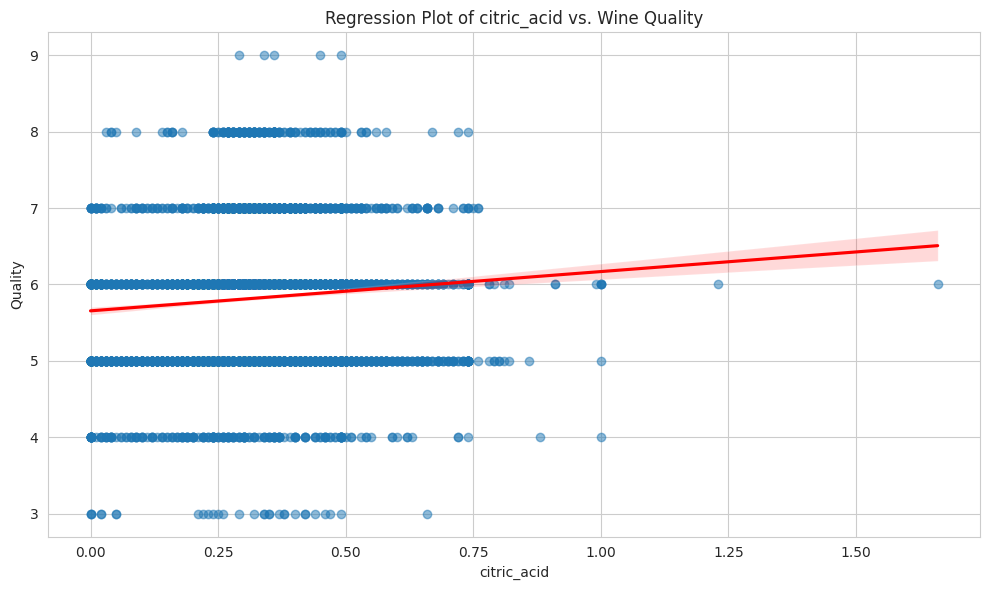

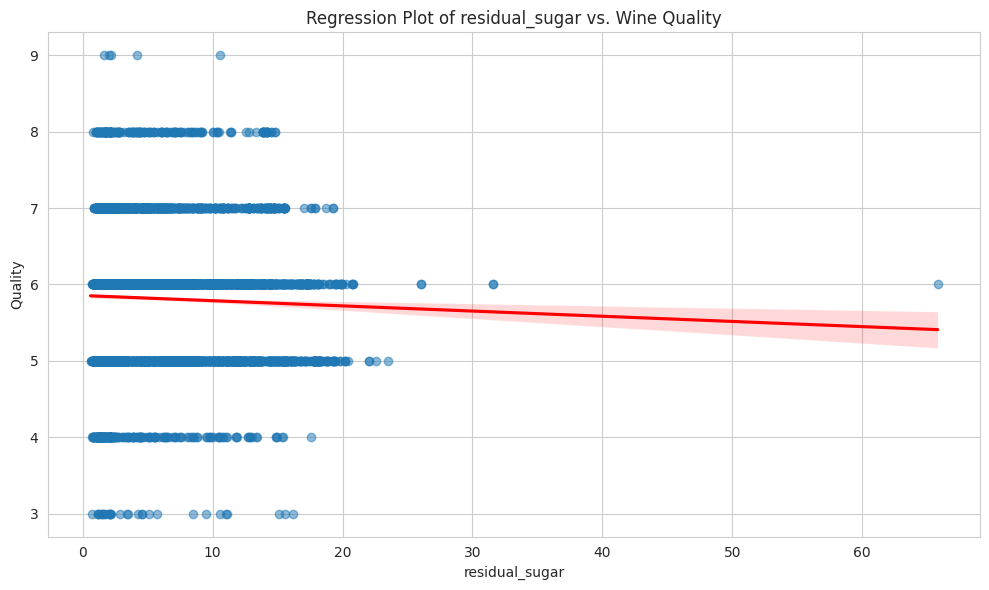

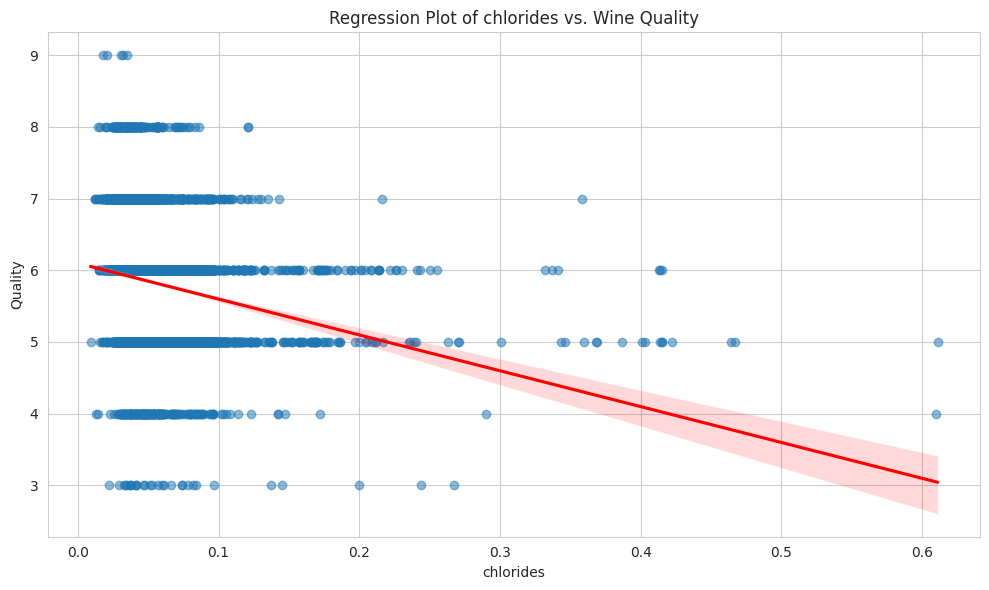

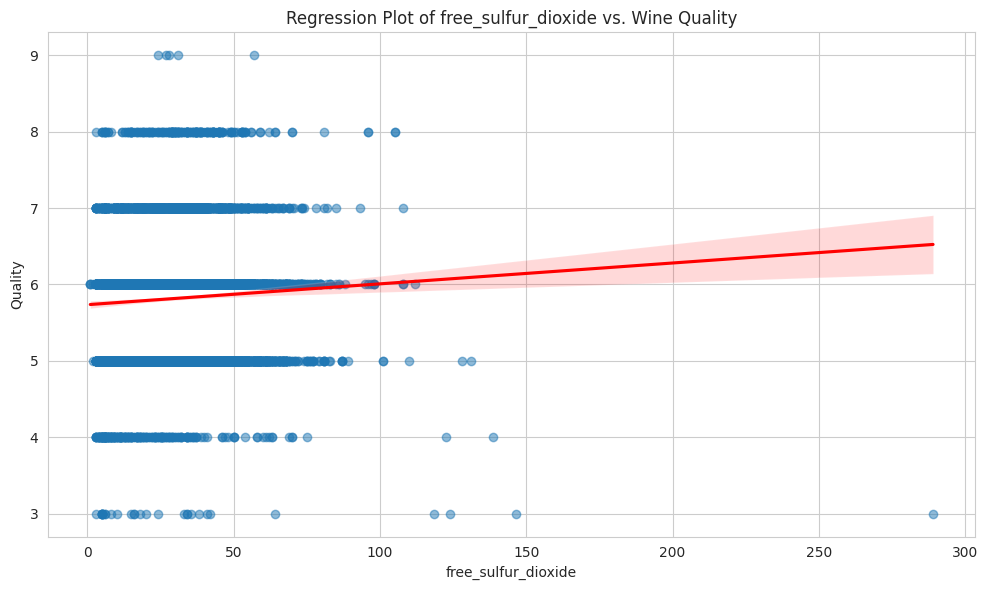

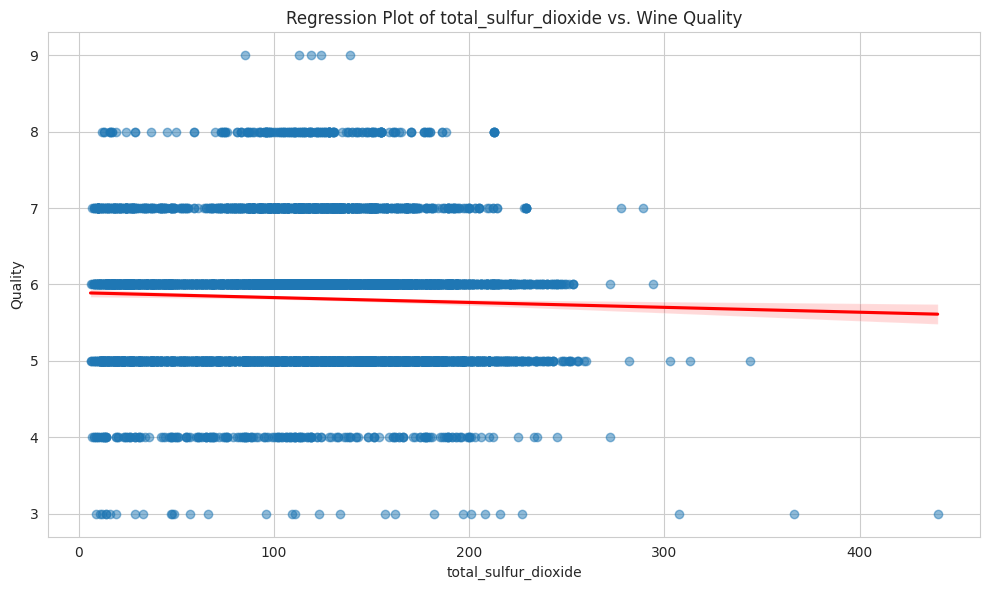

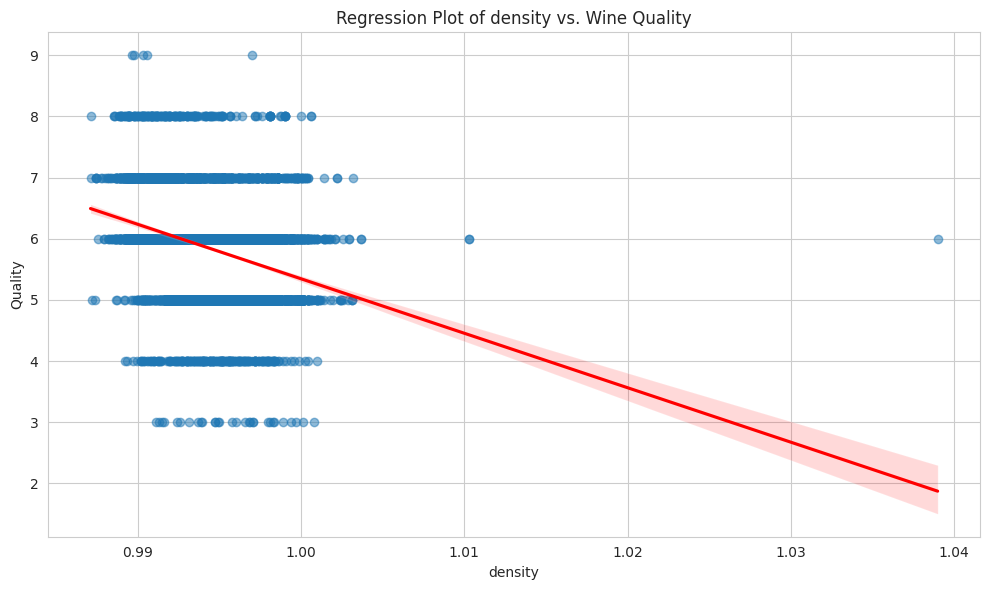

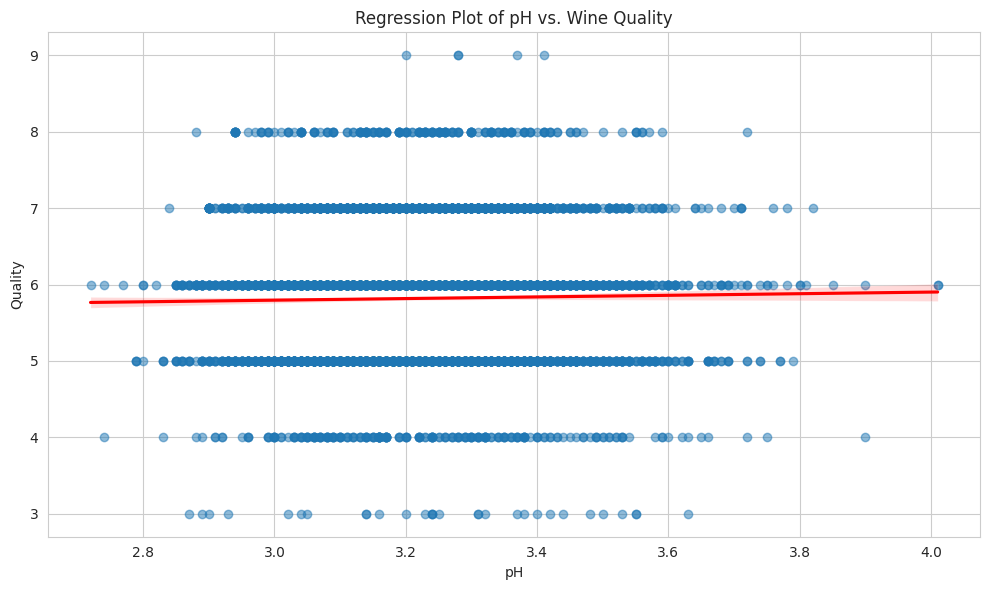

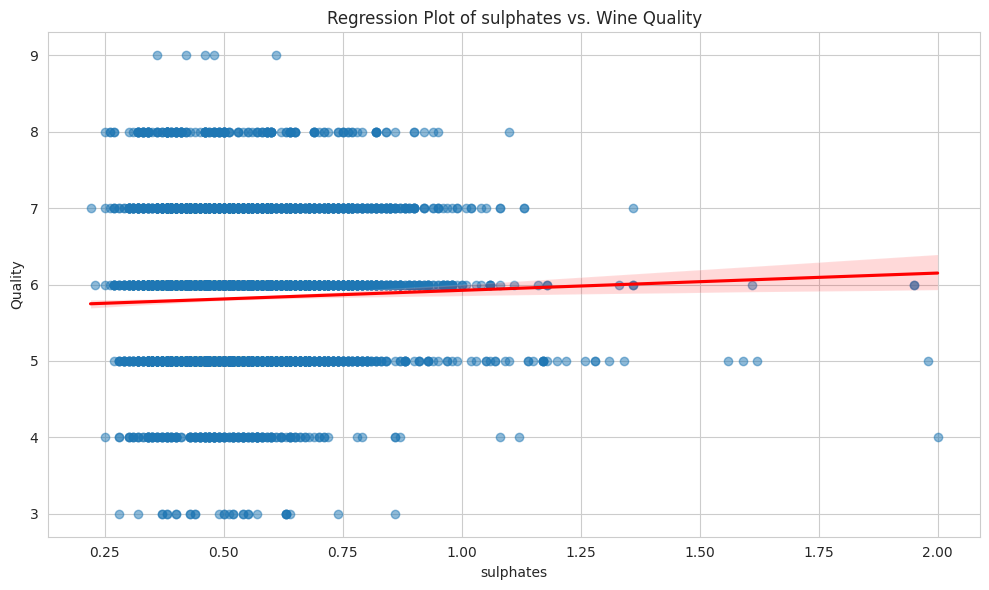

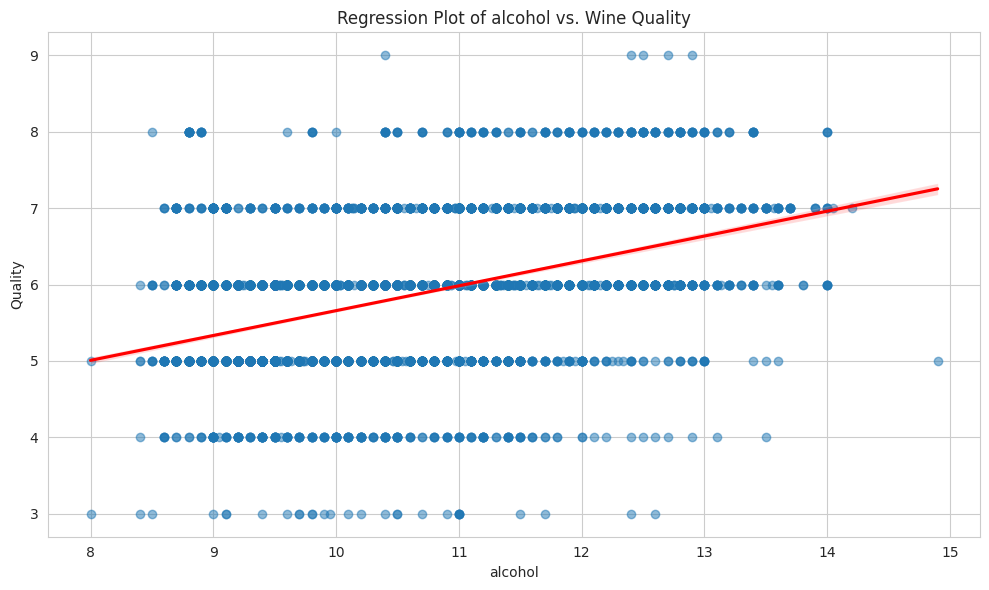

In [17]:
# Plot regplot for each feature
for col in [col for col in df.columns if col != 'quality']:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.regplot(data=df, x=col, y='quality', ax=ax, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot of {col} vs. Wine Quality')
    plt.xlabel(col)
    plt.ylabel('Quality')
    plt.tight_layout()
    plt.show()

In [18]:
# Create correlation matrix
corr = df.corr().round(2)
corr

fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity                  1.00              0.22         0.32   
volatile_acidity               0.22              1.00        -0.38   
citric_acid                    0.32             -0.38         1.00   
residual_sugar                -0.11             -0.20         0.14   
chlorides                      0.30              0.38         0.04   
free_sulfur_dioxide           -0.28             -0.35         0.13   
total_sulfur_dioxide          -0.33             -0.41         0.20   
density                        0.46              0.27         0.10   
pH                            -0.25              0.26        -0.33   
sulphates                      0.30              0.23         0.06   
alcohol                       -0.10             -0.04        -0.01   
quality                       -0.08             -0.27         0.09   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity                  -0.11       0.30                -0.28   
volatile_acidity               -0.20       0.38                -0.35   
citric_acid                     0.14       0.04                 0.13   
residual_sugar                  1.00      -0.13                 0.40   
chlorides                      -0.13       1.00                -0.20   
free_sulfur_dioxide             0.40      -0.20                 1.00   
total_sulfur_dioxide            0.50      -0.28                 0.72   
density                         0.55       0.36                 0.03   
pH                             -0.27       0.04                -0.15   
sulphates                      -0.19       0.40                -0.19   
alcohol                        -0.36      -0.26                -0.18   
quality                        -0.04      -0.20                 0.06   

                      total_sulfur_dioxide  density    pH  sulphates  alcohol  \
fixed_acidity                        -0.33     0.46 -0.25       0.30    -0.10   
volatile_acidity                     -0.41     0.27  0.26       0.23    -0.04   
citric_acid                           0.20     0.10 -0.33       0.06    -0.01   
residual_sugar                        0.50     0.55 -0.27      -0.19    -0.36   
chlorides                            -0.28     0.36  0.04       0.40    -0.26   
free_sulfur_dioxide                   0.72     0.03 -0.15      -0.19    -0.18   
total_sulfur_dioxide                  1.00     0.03 -0.24      -0.28    -0.27   
density                               0.03     1.00  0.01       0.26    -0.69   
pH                                   -0.24     0.01  1.00       0.19     0.12   
sulphates                            -0.28     0.26  0.19       1.00    -0.00   
alcohol                              -0.27    -0.69  0.12      -0.00     1.00   
quality                              -0.04    -0.31  0.02       0.04     0.44   

                      quality  
fixed_acidity           -0.08  
volatile_acidity        -0.27  
citric_acid              0.09  
residual_sugar          -0.04  
chlorides               -0.20  
free_sulfur_dioxide      0.06  
total_sulfur_dioxide    -0.04  
density                 -0.31  
pH                       0.02  
sulphates                0.04  
alcohol                  0.44  
quality                  1.00

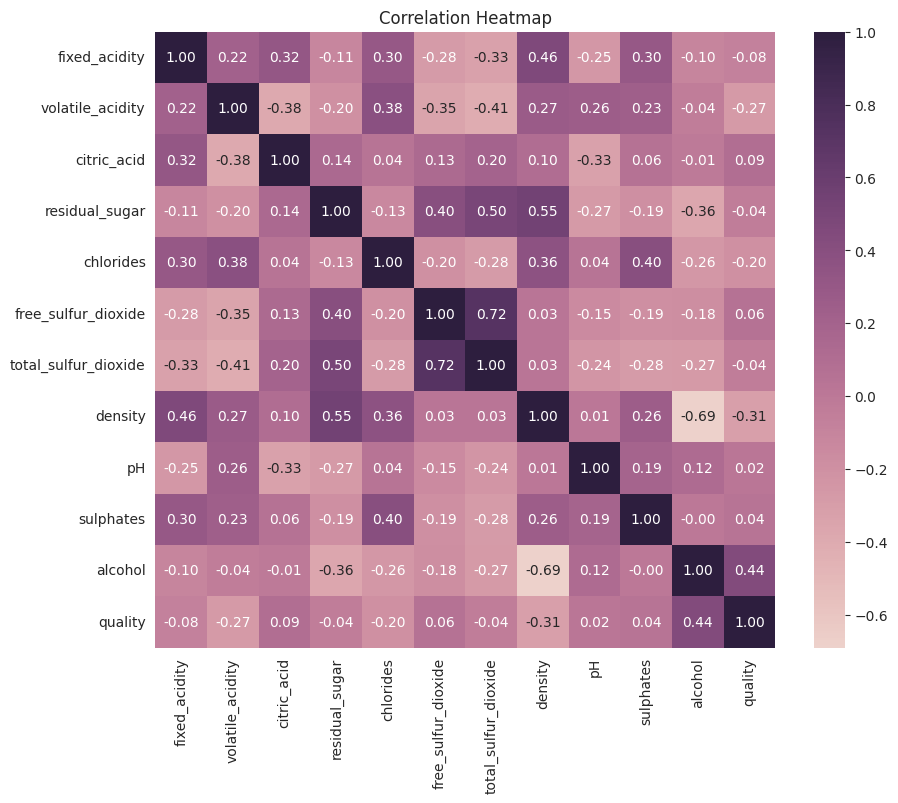

In [19]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap=sns.cubehelix_palette(as_cmap=True), cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Preparing the Data

## Partitioning the Data

In [20]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
# Print the shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}\n")

print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3898, 11)
y_train: (3898, 1)

X_val: (1299, 11)
y_val: (1299, 1)

X_test: (1300, 11)
y_test: (1300, 1)


In [22]:
# Examine training set
X_train.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
5546            6.1              0.30         0.32             2.2      0.042   
3106            7.8              0.26         0.74             7.5      0.044   
3096            6.8              0.27         0.49             1.2      0.044   
3018            7.6              0.14         0.74             1.6      0.040   
4472            5.8              0.21         0.32             1.6      0.045   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
5546                 41.0                 142.0  0.98952  3.31       0.44   
3106                 59.0                 160.0  0.99600  3.22       0.64   
3096                 35.0                 126.0  0.99000  3.13       0.48   
3018                 27.0                 103.0  0.99160  3.07       0.40   
4472                 38.0                  95.0  0.98946  3.23       0.94   

      alcohol  
5546     12.7  
3106     10.0  
3096     12.1  
3018     10.8  
4472     12.4

## Engineering Features

### Polynomials & Interactions

In [23]:
# Create polynomial and interaction features
poly = PolynomialFeatures(degree=3, include_bias=False).set_output(transform="pandas")

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

In [24]:
# Examine the list of features
X_train_poly.columns.tolist()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'fixed_acidity^2',
 'fixed_acidity volatile_acidity',
 'fixed_acidity citric_acid',
 'fixed_acidity residual_sugar',
 'fixed_acidity chlorides',
 'fixed_acidity free_sulfur_dioxide',
 'fixed_acidity total_sulfur_dioxide',
 'fixed_acidity density',
 'fixed_acidity pH',
 'fixed_acidity sulphates',
 'fixed_acidity alcohol',
 'volatile_acidity^2',
 'volatile_acidity citric_acid',
 'volatile_acidity residual_sugar',
 'volatile_acidity chlorides',
 'volatile_acidity free_sulfur_dioxide',
 'volatile_acidity total_sulfur_dioxide',
 'volatile_acidity density',
 'volatile_acidity pH',
 'volatile_acidity sulphates',
 'volatile_acidity alcohol',
 'citric_acid^2',
 'citric_acid residual_sugar',
 'citric_acid chlorides',
 'citric_acid free_sulfur_dioxide',
 'citric_acid total_sulfur_dioxide',
 'citric_acid density',
 'c

In [25]:
# Examine the DataFrame
X_train_poly.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
5546            6.1              0.30         0.32             2.2      0.042   
3106            7.8              0.26         0.74             7.5      0.044   
3096            6.8              0.27         0.49             1.2      0.044   
3018            7.6              0.14         0.74             1.6      0.040   
4472            5.8              0.21         0.32             1.6      0.045   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
5546                 41.0                 142.0  0.98952  3.31       0.44   
3106                 59.0                 160.0  0.99600  3.22       0.64   
3096                 35.0                 126.0  0.99000  3.13       0.48   
3018                 27.0                 103.0  0.99160  3.07       0.40   
4472                 38.0                  95.0  0.98946  3.23       0.94   

      alcohol  fixed_acidity^2  fixed_acidity volatile_acidity  \
5546     12.7            37.21                           1.830   
3106     10.0            60.84                           2.028   
3096     12.1            46.24                           1.836   
3018     10.8            57.76                           1.064   
4472     12.4            33.64                           1.218   

      fixed_acidity citric_acid  fixed_acidity residual_sugar  \
5546                      1.952                         13.42   
3106                      5.772                         58.50   
3096                      3.332                          8.16   
3018                      5.624                         12.16   
4472                      1.856                          9.28   

      fixed_acidity chlorides  fixed_acidity free_sulfur_dioxide  \
5546                   0.2562                              250.1   
3106                   0.3432                              460.2   
3096                   0.2992                              238.0   
3018                   0.3040                              205.2   
4472                   0.2610                              220.4   

      fixed_acidity total_sulfur_dioxide  fixed_acidity density  \
5546                               866.2               6.036072   
3106                              1248.0               7.768800   
3096                               856.8               6.732000   
3018                               782.8               7.536160   
4472                               551.0               5.738868   

      fixed_acidity pH  fixed_acidity sulphates  fixed_acidity alcohol  \
5546            20.191                    2.684                  77.47   
3106            25.116                    4.992                  78.00   
3096            21.284                    3.264                  82.28   
3018            23.332                    3.040                  82.08   
4472            18.734                    5.452                  71.92   

      volatile_acidity^2  volatile_acidity citric_acid  \
5546              0.0900                        0.0960   
3106              0.0676                        0.1924   
3096              0.0729                        0.1323   
3018              0.0196                        0.1036   
4472              0.0441                        0.0672   

      volatile_acidity residual_sugar  volatile_acidity chlorides  \
5546                            0.660                     0.01260   
3106                            1.950                     0.01144   
3096                            0.324                     0.01188   
3018                            0.224                     0.00560   
4472                            0.336                     0.00945   

      volatile_acidity free_sulfur_dioxide  \
5546                                 12.30   
3106                                 15.34   
3096                                  9.45   
3018                                  3.78   
4472             

### Ratio Interactions

In [26]:
# Create ratio interaction features
ratio_transformer = RelativeFeatures(
    variables=X_train.columns.tolist(),
    reference=X_train.columns.tolist(),
    fill_value=1,
    func=['div']
)

X_train_ratio = ratio_transformer.fit_transform(X_train)
X_val_ratio = ratio_transformer.transform(X_val)
X_test_ratio = ratio_transformer.transform(X_test)

In [27]:
# Examine the list of features
X_train_ratio.columns.tolist()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'fixed_acidity_div_fixed_acidity',
 'volatile_acidity_div_fixed_acidity',
 'citric_acid_div_fixed_acidity',
 'residual_sugar_div_fixed_acidity',
 'chlorides_div_fixed_acidity',
 'free_sulfur_dioxide_div_fixed_acidity',
 'total_sulfur_dioxide_div_fixed_acidity',
 'density_div_fixed_acidity',
 'pH_div_fixed_acidity',
 'sulphates_div_fixed_acidity',
 'alcohol_div_fixed_acidity',
 'fixed_acidity_div_volatile_acidity',
 'volatile_acidity_div_volatile_acidity',
 'citric_acid_div_volatile_acidity',
 'residual_sugar_div_volatile_acidity',
 'chlorides_div_volatile_acidity',
 'free_sulfur_dioxide_div_volatile_acidity',
 'total_sulfur_dioxide_div_volatile_acidity',
 'density_div_volatile_acidity',
 'pH_div_volatile_acidity',
 'sulphates_div_volatile_acidity',
 'alcohol_div_volatile_acidity',
 'fixed_acidity_div_citri

In [28]:
# Examine the DataFrame
X_train_ratio.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
5546            6.1              0.30         0.32             2.2      0.042   
3106            7.8              0.26         0.74             7.5      0.044   
3096            6.8              0.27         0.49             1.2      0.044   
3018            7.6              0.14         0.74             1.6      0.040   
4472            5.8              0.21         0.32             1.6      0.045   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
5546                 41.0                 142.0  0.98952  3.31       0.44   
3106                 59.0                 160.0  0.99600  3.22       0.64   
3096                 35.0                 126.0  0.99000  3.13       0.48   
3018                 27.0                 103.0  0.99160  3.07       0.40   
4472                 38.0                  95.0  0.98946  3.23       0.94   

      alcohol  fixed_acidity_div_fixed_acidity  \
5546     12.7                              1.0   
3106     10.0                              1.0   
3096     12.1                              1.0   
3018     10.8                              1.0   
4472     12.4                              1.0   

      volatile_acidity_div_fixed_acidity  citric_acid_div_fixed_acidity  \
5546                            0.049180                       0.052459   
3106                            0.033333                       0.094872   
3096                            0.039706                       0.072059   
3018                            0.018421                       0.097368   
4472                            0.036207                       0.055172   

      residual_sugar_div_fixed_acidity  chlorides_div_fixed_acidity  \
5546                          0.360656                     0.006885   
3106                          0.961538                     0.005641   
3096                          0.176471                     0.006471   
3018                          0.210526                     0.005263   
4472                          0.275862                     0.007759   

      free_sulfur_dioxide_div_fixed_acidity  \
5546                               6.721311   
3106                               7.564103   
3096                               5.147059   
3018                               3.552632   
4472                               6.551724   

      total_sulfur_dioxide_div_fixed_acidity  density_div_fixed_acidity  \
5546                               23.278689                   0.162216   
3106                               20.512821                   0.127692   
3096                               18.529412                   0.145588   
3018                               13.552632                   0.130474   
4472                               16.379310                   0.170597   

      pH_div_fixed_acidity  sulphates_div_fixed_acidity  \
5546              0.542623                     0.072131   
3106              0.412821                     0.082051   
3096              0.460294                     0.070588   
3018              0.403947                     0.052632   
4472              0.556897                     0.162069   

      alcohol_div_fixed_acidity  fixed_acidity_div_volatile_acidity  \
5546                   2.081967                           20.333333   
3106                   1.282051                           30.000000   
3096                   1.779412                           25.185185   
3018                   1.421053                           54.285714   
4472                   2.137931                           27.619048   

      volatile_acidity_div_volatile_acidity  citric_acid_div_volatile_acidity  \
5546                                    1.0                          1.066667   
3106                                    1.0                          2.846154   
3096                                    1.0                          1.814815   
3018                                 

### Concatenate Features

In [29]:
# Concatenate the DataFrames
X_train_concat = pd.concat([X_train_poly, X_train_ratio], axis=1)
X_val_concat = pd.concat([X_val_poly, X_val_ratio], axis=1)
X_test_concat = pd.concat([X_test_poly, X_test_ratio], axis=1)

In [30]:
# Examine the list of features
X_train_concat.columns.tolist()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'fixed_acidity^2',
 'fixed_acidity volatile_acidity',
 'fixed_acidity citric_acid',
 'fixed_acidity residual_sugar',
 'fixed_acidity chlorides',
 'fixed_acidity free_sulfur_dioxide',
 'fixed_acidity total_sulfur_dioxide',
 'fixed_acidity density',
 'fixed_acidity pH',
 'fixed_acidity sulphates',
 'fixed_acidity alcohol',
 'volatile_acidity^2',
 'volatile_acidity citric_acid',
 'volatile_acidity residual_sugar',
 'volatile_acidity chlorides',
 'volatile_acidity free_sulfur_dioxide',
 'volatile_acidity total_sulfur_dioxide',
 'volatile_acidity density',
 'volatile_acidity pH',
 'volatile_acidity sulphates',
 'volatile_acidity alcohol',
 'citric_acid^2',
 'citric_acid residual_sugar',
 'citric_acid chlorides',
 'citric_acid free_sulfur_dioxide',
 'citric_acid total_sulfur_dioxide',
 'citric_acid density',
 'c

In [31]:
# Examine the DataFrame
X_train_concat.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
5546            6.1              0.30         0.32             2.2      0.042   
3106            7.8              0.26         0.74             7.5      0.044   
3096            6.8              0.27         0.49             1.2      0.044   
3018            7.6              0.14         0.74             1.6      0.040   
4472            5.8              0.21         0.32             1.6      0.045   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
5546                 41.0                 142.0  0.98952  3.31       0.44   
3106                 59.0                 160.0  0.99600  3.22       0.64   
3096                 35.0                 126.0  0.99000  3.13       0.48   
3018                 27.0                 103.0  0.99160  3.07       0.40   
4472                 38.0                  95.0  0.98946  3.23       0.94   

      alcohol  fixed_acidity^2  fixed_acidity volatile_acidity  \
5546     12.7            37.21                           1.830   
3106     10.0            60.84                           2.028   
3096     12.1            46.24                           1.836   
3018     10.8            57.76                           1.064   
4472     12.4            33.64                           1.218   

      fixed_acidity citric_acid  fixed_acidity residual_sugar  \
5546                      1.952                         13.42   
3106                      5.772                         58.50   
3096                      3.332                          8.16   
3018                      5.624                         12.16   
4472                      1.856                          9.28   

      fixed_acidity chlorides  fixed_acidity free_sulfur_dioxide  \
5546                   0.2562                              250.1   
3106                   0.3432                              460.2   
3096                   0.2992                              238.0   
3018                   0.3040                              205.2   
4472                   0.2610                              220.4   

      fixed_acidity total_sulfur_dioxide  fixed_acidity density  \
5546                               866.2               6.036072   
3106                              1248.0               7.768800   
3096                               856.8               6.732000   
3018                               782.8               7.536160   
4472                               551.0               5.738868   

      fixed_acidity pH  fixed_acidity sulphates  fixed_acidity alcohol  \
5546            20.191                    2.684                  77.47   
3106            25.116                    4.992                  78.00   
3096            21.284                    3.264                  82.28   
3018            23.332                    3.040                  82.08   
4472            18.734                    5.452                  71.92   

      volatile_acidity^2  volatile_acidity citric_acid  \
5546              0.0900                        0.0960   
3106              0.0676                        0.1924   
3096              0.0729                        0.1323   
3018              0.0196                        0.1036   
4472              0.0441                        0.0672   

      volatile_acidity residual_sugar  volatile_acidity chlorides  \
5546                            0.660                     0.01260   
3106                            1.950                     0.01144   
3096                            0.324                     0.01188   
3018                            0.224                     0.00560   
4472                            0.336                     0.00945   

      volatile_acidity free_sulfur_dioxide  \
5546                                 12.30   
3106                                 15.34   
3096                                  9.45   
3018                                  3.78   
4472             

### De-Duplicate Features

In [32]:
# Original features
original_features = set([
    'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
    'pH', 'sulphates', 'alcohol'
])

# Function to remove unwanted features
def remove_unwanted_features(df, original_features):
    # Identify columns where features are divided by themselves
    self_divided_columns = [col for col in df.columns if '_div_' in col and col.split('_div_')[0] == col.split('_div_')[1]]

    # Drop these columns from the DataFrame
    df = df.drop(columns=self_divided_columns)

    # Ensure original features are not duplicated
    for feature in original_features:
        if feature in df.columns:
            df = df.loc[:, ~(df.columns.duplicated(keep='first') & (df.columns == feature))]

    return df

# Apply the function
X_train_deduped = remove_unwanted_features(X_train_concat, original_features)
X_val_deduped = remove_unwanted_features(X_val_concat, original_features)
X_test_deduped = remove_unwanted_features(X_test_concat, original_features)

In [33]:
# Examine the list of features
X_train_deduped.columns.tolist()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'fixed_acidity^2',
 'fixed_acidity volatile_acidity',
 'fixed_acidity citric_acid',
 'fixed_acidity residual_sugar',
 'fixed_acidity chlorides',
 'fixed_acidity free_sulfur_dioxide',
 'fixed_acidity total_sulfur_dioxide',
 'fixed_acidity density',
 'fixed_acidity pH',
 'fixed_acidity sulphates',
 'fixed_acidity alcohol',
 'volatile_acidity^2',
 'volatile_acidity citric_acid',
 'volatile_acidity residual_sugar',
 'volatile_acidity chlorides',
 'volatile_acidity free_sulfur_dioxide',
 'volatile_acidity total_sulfur_dioxide',
 'volatile_acidity density',
 'volatile_acidity pH',
 'volatile_acidity sulphates',
 'volatile_acidity alcohol',
 'citric_acid^2',
 'citric_acid residual_sugar',
 'citric_acid chlorides',
 'citric_acid free_sulfur_dioxide',
 'citric_acid total_sulfur_dioxide',
 'citric_acid density',
 'c

In [34]:
# Examine the DataFrame
X_train_deduped.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
5546            6.1              0.30         0.32             2.2      0.042   
3106            7.8              0.26         0.74             7.5      0.044   
3096            6.8              0.27         0.49             1.2      0.044   
3018            7.6              0.14         0.74             1.6      0.040   
4472            5.8              0.21         0.32             1.6      0.045   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
5546                 41.0                 142.0  0.98952  3.31       0.44   
3106                 59.0                 160.0  0.99600  3.22       0.64   
3096                 35.0                 126.0  0.99000  3.13       0.48   
3018                 27.0                 103.0  0.99160  3.07       0.40   
4472                 38.0                  95.0  0.98946  3.23       0.94   

      alcohol  fixed_acidity^2  fixed_acidity volatile_acidity  \
5546     12.7            37.21                           1.830   
3106     10.0            60.84                           2.028   
3096     12.1            46.24                           1.836   
3018     10.8            57.76                           1.064   
4472     12.4            33.64                           1.218   

      fixed_acidity citric_acid  fixed_acidity residual_sugar  \
5546                      1.952                         13.42   
3106                      5.772                         58.50   
3096                      3.332                          8.16   
3018                      5.624                         12.16   
4472                      1.856                          9.28   

      fixed_acidity chlorides  fixed_acidity free_sulfur_dioxide  \
5546                   0.2562                              250.1   
3106                   0.3432                              460.2   
3096                   0.2992                              238.0   
3018                   0.3040                              205.2   
4472                   0.2610                              220.4   

      fixed_acidity total_sulfur_dioxide  fixed_acidity density  \
5546                               866.2               6.036072   
3106                              1248.0               7.768800   
3096                               856.8               6.732000   
3018                               782.8               7.536160   
4472                               551.0               5.738868   

      fixed_acidity pH  fixed_acidity sulphates  fixed_acidity alcohol  \
5546            20.191                    2.684                  77.47   
3106            25.116                    4.992                  78.00   
3096            21.284                    3.264                  82.28   
3018            23.332                    3.040                  82.08   
4472            18.734                    5.452                  71.92   

      volatile_acidity^2  volatile_acidity citric_acid  \
5546              0.0900                        0.0960   
3106              0.0676                        0.1924   
3096              0.0729                        0.1323   
3018              0.0196                        0.1036   
4472              0.0441                        0.0672   

      volatile_acidity residual_sugar  volatile_acidity chlorides  \
5546                            0.660                     0.01260   
3106                            1.950                     0.01144   
3096                            0.324                     0.01188   
3018                            0.224                     0.00560   
4472                            0.336                     0.00945   

      volatile_acidity free_sulfur_dioxide  \
5546                                 12.30   
3106                                 15.34   
3096                                  9.45   
3018                                  3.78   
4472             

In [35]:
# Number of features after feature engineering
print(f"There are {X_train_deduped.shape[1]} features")

There are 473 features


## Standardizing the Data

In [36]:
# Standardize the sets
scaler = StandardScaler().set_output(transform="pandas")

X_train_scaled = scaler.fit_transform(X_train_deduped)
X_val_scaled = scaler.transform(X_val_deduped)
X_test_scaled = scaler.transform(X_test_deduped)

## Feature Selection

In [37]:
# Feature selection with RFECV
feature_selector = RFECV(
    estimator=RandomForestRegressor(random_state=42),
    step=10,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
).set_output(transform="pandas")

In [38]:
# Use the feature selector
X_train_selected = feature_selector.fit_transform(X_train_scaled, y_train.values.ravel())
X_val_selected = feature_selector.transform(X_val_scaled)
X_test_selected = feature_selector.transform(X_test_scaled)

# Get the selected features
selected_features = X_train_scaled.columns[feature_selector.support_]
print(f"Selected Features: {selected_features}")

# Print number of features
print(f"\nThere are {len(selected_features)} features after feature selection")

# Define the base directory to save files
base_dir = "/content/drive/My Drive/Datasets/wine_quality/"

# Save the files
X_train_selected.to_csv(base_dir + 'X_train_selected.csv', index=False)
X_val_selected.to_csv(base_dir + 'X_val_selected.csv', index=False)
X_test_selected.to_csv(base_dir + 'X_test_selected.csv', index=False)

y_train.to_csv(base_dir + 'y_train.csv', index=False, header=True)
y_val.to_csv(base_dir + 'y_val.csv', index=False, header=True)
y_test.to_csv(base_dir + 'y_test.csv', index=False, header=True)

Fitting estimator with 473 features.
Fitting estimator with 463 features.
Fitting estimator with 453 features.
Fitting estimator with 443 features.
Fitting estimator with 433 features.
Fitting estimator with 423 features.
Fitting estimator with 413 features.
Fitting estimator with 403 features.
Fitting estimator with 393 features.
Fitting estimator with 383 features.
Fitting estimator with 373 features.
Fitting estimator with 363 features.
Fitting estimator with 353 features.
Fitting estimator with 343 features.
Fitting estimator with 333 features.
Fitting estimator with 323 features.
Fitting estimator with 313 features.
Fitting estimator with 303 features.
Fitting estimator with 293 features.
Fitting estimator with 283 features.
Fitting estimator with 273 features.
Fitting estimator with 263 features.
Fitting estimator with 253 features.
Fitting estimator with 243 features.
Fitting estimator with 233 features.
Fitting estimator with 223 features.
Fitting estimator with 213 features.
F

In [39]:
# Define the base directory
base_dir = "/content/drive/My Drive/Datasets/wine_quality/"

# Load the datasets
X_train_selected = pd.read_csv(base_dir + 'X_train_selected.csv')
X_val_selected = pd.read_csv(base_dir + 'X_val_selected.csv')
X_test_selected = pd.read_csv(base_dir + 'X_test_selected.csv')

y_train = pd.read_csv(base_dir + 'y_train.csv')
y_val = pd.read_csv(base_dir + 'y_val.csv')
y_test = pd.read_csv(base_dir + 'y_test.csv')

In [40]:
X_train_selected.head()

volatile_acidity pH  density^2  density alcohol  pH alcohol  \
0            -0.165300  -1.709230         1.842892    1.913313   
1            -0.450047   0.443638        -0.400088   -0.356341   
2            -0.435609  -1.550240         1.337059    0.952569   
3            -1.194631  -1.019718         0.244592   -0.135766   
4            -0.740461  -1.729098         1.586837    1.455321   

   fixed_acidity^2 volatile_acidity  fixed_acidity^2 citric_acid  \
0                         -0.532097                    -0.420851   
1                         -0.196747                     1.825681   
2                         -0.436882                     0.308473   
3                         -0.753718                     1.671056   
4                         -0.827338                    -0.498353   

   fixed_acidity^2 residual_sugar  fixed_acidity^2 chlorides  \
0                       -0.789840                  -0.563219   
1                        0.708156                  -0.167506   
2                       -0.895354                  -0.395669   
3                       -0.747618                  -0.297699   
4                       -0.902011                  -0.580629   

   fixed_acidity^2 free_sulfur_dioxide  fixed_acidity^2 total_sulfur_dioxide  \
0                             0.004992                             -0.159026   
1                             2.341994                              1.323216   
2                             0.110058                              0.021624   
3                             0.043388                              0.062602   
4                            -0.275013                             -0.854431   

   fixed_acidity^2 sulphates  fixed_acidity^2 alcohol  \
0                  -0.690851                -0.368589   
1                   0.524192                 0.216336   
2                  -0.377318                 0.005780   
3                  -0.328382                 0.282687   
4                   0.130255                -0.607286   

   fixed_acidity volatile_acidity citric_acid  \
0                                   -0.262306   
1                                    1.262520   
2                                    0.260965   
3                                    0.073878   
4                                   -0.588626   

   fixed_acidity volatile_acidity chlorides  \
0                                 -0.451471   
1                                 -0.379582   
2                                 -0.428670   
3                                 -0.650774   
4                                 -0.579594   

   fixed_acidity volatile_acidity free_sulfur_dioxide  \
0                                           0.232280    
1                                           1.307503    
2                                          -0.027237    
3                                          -0.883425    
4                                          -0.460391    

   fixed_acidity volatile_acidity total_sulfur_dioxide  \
0                                           0.079779     
1                                           0.512528     
2                                          -0.111241     
3                                          -0.926540     
4                                          -0.885569     

   fixed_acidity volatile_acidity density  fixed_acidity citric_acid pH  \
0                               -0.454186                     -0.253343   
1                               -0.302795                      2.637555   
2                               -0.449249                      0.692757   
3                               -1.001453                      2.322789   
4                               -0.892762                     -0.364508   

   fixed_acidity citric_acid alcohol  fixed_acidity residual_sugar chlorides  \
0                           0.004284                               -0.711993   
1                           2.302030                                0.264530   
2                          

## Dimensionality Reduction

In [41]:
from sklearn.decomposition import KernelPCA

# Kernel PCA to reduce dimensionality
kpca = KernelPCA(n_components=20, kernel='cosine', random_state=42).set_output(transform="pandas")

X_train_reduced = kpca.fit_transform(X_train_selected)
X_val_reduced = kpca.transform(X_val_selected)
X_test_reduced = kpca.transform(X_test_selected)

In [42]:
# Examine the DataFrame
X_train_reduced.head()

kernelpca0  kernelpca1  kernelpca2  kernelpca3  kernelpca4  kernelpca5  \
0   -0.360994   -0.514231    0.456102    0.401195    0.137472    0.161774   
1    0.557909   -0.018029    0.593417   -0.345601   -0.065540    0.085236   
2   -0.423439   -0.489652    0.463771   -0.096813    0.078712    0.379504   
3   -0.199539   -0.477941   -0.001678   -0.549288   -0.186151    0.361344   
4   -0.241673   -0.272070    0.598470   -0.151927    0.223370   -0.551450   

   kernelpca6  kernelpca7  kernelpca8  kernelpca9  kernelpca10  kernelpca11  \
0   -0.100384    0.205556    0.194285    0.012944    -0.027239    -0.040851   
1   -0.014482    0.228428   -0.306358   -0.012866     0.090949     0.170476   
2   -0.017085    0.203864   -0.009201   -0.192057     0.084402     0.007007   
3   -0.062961    0.226421   -0.150686   -0.058519     0.120009     0.156074   
4    0.035014    0.018808    0.010982   -0.248594    -0.008549    -0.004350   

   kernelpca12  kernelpca13  kernelpca14  kernelpca15  kernelpca16  \
0    -0.075251    -0.037923     0.004386    -0.041288     0.009630   
1    -0.129596    -0.010482    -0.098960     0.010497     0.083719   
2     0.053200    -0.168395     0.019096    -0.073761     0.029963   
3     0.047529     0.038450     0.004993    -0.105129    -0.071715   
4     0.010504     0.015159     0.003209    -0.056444     0.032234   

   kernelpca17  kernelpca18  kernelpca19  
0    -0.000597     0.033279     0.006791  
1     0.067712    -0.050731    -0.009755  
2    -0.049759     0.020883    -0.028460  
3    -0.033919    -0.051865    -0.017335  
4     0.028307     0.029457    -0.001289

## Array Conversion

In [43]:
# Convert labels to arrays
y_train_np = y_train.values.ravel()
y_val_np = y_val.values.ravel()
y_test_np = y_test.values.ravel()

In [44]:
# Examine the shape
print(f"Shape of y_train_np: {y_train_np.shape}")

Shape of y_train_np: (3898,)


## PT Tabular Datasets

In [45]:
# Create PyTorch Tabular datasets
train_df = pd.concat([X_train_reduced, y_train], axis=1)
val_df = pd.concat([X_val_reduced, y_val], axis=1)
test_df = pd.concat([X_test_reduced, y_test], axis=1)

In [46]:
# Examine the DataFrame
train_df.head()

kernelpca0  kernelpca1  kernelpca2  kernelpca3  kernelpca4  kernelpca5  \
0   -0.360994   -0.514231    0.456102    0.401195    0.137472    0.161774   
1    0.557909   -0.018029    0.593417   -0.345601   -0.065540    0.085236   
2   -0.423439   -0.489652    0.463771   -0.096813    0.078712    0.379504   
3   -0.199539   -0.477941   -0.001678   -0.549288   -0.186151    0.361344   
4   -0.241673   -0.272070    0.598470   -0.151927    0.223370   -0.551450   

   kernelpca6  kernelpca7  kernelpca8  kernelpca9  kernelpca10  kernelpca11  \
0   -0.100384    0.205556    0.194285    0.012944    -0.027239    -0.040851   
1   -0.014482    0.228428   -0.306358   -0.012866     0.090949     0.170476   
2   -0.017085    0.203864   -0.009201   -0.192057     0.084402     0.007007   
3   -0.062961    0.226421   -0.150686   -0.058519     0.120009     0.156074   
4    0.035014    0.018808    0.010982   -0.248594    -0.008549    -0.004350   

   kernelpca12  kernelpca13  kernelpca14  kernelpca15  kernelpca16  \
0    -0.075251    -0.037923     0.004386    -0.041288     0.009630   
1    -0.129596    -0.010482    -0.098960     0.010497     0.083719   
2     0.053200    -0.168395     0.019096    -0.073761     0.029963   
3     0.047529     0.038450     0.004993    -0.105129    -0.071715   
4     0.010504     0.015159     0.003209    -0.056444     0.032234   

   kernelpca17  kernelpca18  kernelpca19  quality  
0    -0.000597     0.033279     0.006791        7  
1     0.067712    -0.050731    -0.009755        6  
2    -0.049759     0.020883    -0.028460        7  
3    -0.033919    -0.051865    -0.017335        7  
4     0.028307     0.029457    -0.001289        8

# Model Selection

In [47]:
# Class to train and evaluate a group of regression models
class UnifiedRegressor:
    def __init__(self, model_type, **kwargs):
        self.model_type = model_type.lower()
        self.kwargs = kwargs
        self.model = None
        self.is_pytorch_tabular = self.model_type in ['tabnet', 'tabtransformer', 'node', 'gandalf']
        if not self.is_pytorch_tabular:
            self._init_model()

    def _init_model(self):
        """Initializes traditional ML models based on the specified model type."""
        model_mapping = {
            'linear': LinearRegression,
            'svm': SVR,
            'randomforest': RandomForestRegressor,
            'extratrees': ExtraTreesRegressor,
            'histgradientboosting': HistGradientBoostingRegressor,
            'xgboost': XGBRegressor,
            'catboost': CatBoostRegressor,
            'lightgbm': LGBMRegressor,
        }
        model_class = model_mapping.get(self.model_type)
        if model_class is None:
            raise ValueError(f"Unsupported model type: {self.model_type}")
        self.model = model_class(**self.kwargs)

    def fit(self, X_train, y_train, X_val=None, y_val=None, train_df=None, val_df=None):
        """Fits the model to the training data using appropriate data formats."""
        if self.is_pytorch_tabular:
            if train_df is None or val_df is None:
                raise ValueError("Full dataset DataFrames are required for PyTorch Tabular models.")
            self._init_pytorch_tabular(train_df, val_df)
        else:
            self.model.fit(X_train, y_train)

    def _init_pytorch_tabular(self, train_df, val_df):
        """Initializes and fits PyTorch Tabular models using full dataset DataFrames."""
        target_col = 'quality'
        self.data_config = DataConfig(
            target=[target_col],
            continuous_cols=[col for col in train_df.columns if col != target_col],
            num_workers=7
        )

        model_config_class = {
            'tabnet': TabNetModelConfig,
            'tabtransformer': TabTransformerConfig,
            'node': NodeConfig,
            'gandalf': GANDALFConfig
        }.get(self.model_type)
        if not model_config_class:
            raise ValueError(f"Unsupported PyTorch Tabular model type: {self.model_type}")

        model_config = model_config_class(task="regression", **self.kwargs)
        self.model = TabularModel(
            data_config=self.data_config,
            model_config=model_config,
            optimizer_config=OptimizerConfig(),
            trainer_config=TrainerConfig(max_epochs=100, batch_size=32),
            verbose=False
        )
        self.model.fit(train=train_df, validation=val_df)

    def predict(self, X_test, test_df, round_predictions=False):
        """Predicts outcomes for the given data. Rounds predictions if specified."""
        if self.is_pytorch_tabular:
            if test_df is None:
                raise ValueError("Full dataset DataFrame is required for PyTorch Tabular models.")
            if round_predictions == False:
                predictions = self.model.predict(test_df)
            else:
                predictions = np.rint(self.model.predict(test_df))
        else:
            if round_predictions == False:
                predictions = self.model.predict(X_test)
            else:
                predictions = np.rint(self.model.predict(X_test))

        return predictions

    def evaluate(self, X_test, test_df, y_test):
        """Evaluates the model on the given data and returns common regression metrics."""
        y_pred = self.predict(X_test, test_df)
        if not isinstance(y_pred, np.ndarray):
            y_pred = y_pred.values.ravel()

        metrics = {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'MAPE': mean_absolute_percentage_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
        }
        return metrics

    def print_metrics(self, metrics):
        """Prints the evaluation metrics."""
        print("Model Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print()

In [48]:
# Define the models to evaluate
models_to_evaluate = {
    'linear': {},
    'svm': {'kernel': 'rbf'},
    'randomforest': {},
    'extratrees': {},
    'histgradientboosting': {},
    'xgboost': {},
    'catboost': {'silent': True},
    'lightgbm': {'verbose': -1},
    'tabnet': {},
    'tabtransformer': {},
    'node': {},
    'gandalf': {}
}

# Iterate through the defined models and evaluate each
all_metrics = {}

for model_type, params in models_to_evaluate.items():
    print(f"Evaluating {model_type} model...")
    model = UnifiedRegressor(model_type=model_type, **params)

    model.fit(X_train_reduced, y_train_np, X_val_reduced, y_val_np, train_df, val_df)

    # Evaluate the model
    metrics = model.evaluate(X_test_reduced, test_df, y_test_np)
    all_metrics[model_type] = metrics

    # Print the metrics
    model.print_metrics(metrics)

Evaluating linear model...
Model Performance:
MSE: 0.5638
RMSE: 0.7509
MAE: 0.5838
MAPE: 0.1052
R2: 0.2696

Evaluating svm model...
Model Performance:
MSE: 0.4941
RMSE: 0.7029
MAE: 0.5272
MAPE: 0.0945
R2: 0.3600

Evaluating randomforest model...
Model Performance:
MSE: 0.3990
RMSE: 0.6317
MAE: 0.4693
MAPE: 0.0858
R2: 0.4832

Evaluating extratrees model...
Model Performance:
MSE: 0.3748
RMSE: 0.6122
MAE: 0.4217
MAPE: 0.0776
R2: 0.5145

Evaluating histgradientboosting model...
Model Performance:
MSE: 0.4441
RMSE: 0.6664
MAE: 0.5071
MAPE: 0.0920
R2: 0.4248

Evaluating xgboost model...
Model Performance:
MSE: 0.4471
RMSE: 0.6687
MAE: 0.4818
MAPE: 0.0876
R2: 0.4208

Evaluating catboost model...
Model Performance:
MSE: 0.4298
RMSE: 0.6556
MAE: 0.4921
MAPE: 0.0893
R2: 0.4433

Evaluating lightgbm model...


INFO:lightning_fabric.utilities.seed:Seed set to 42


Model Performance:
MSE: 0.4436
RMSE: 0.6660
MAE: 0.5082
MAPE: 0.0922
R2: 0.4254

Evaluating tabnet model...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │
│ 1 │ _backbone        │ TabNetBackbone │  7.0 K │
│ 2 │ _head            │ Identity       │      0 │
│ 3 │ loss             │ MSELoss        │      0 │
└───┴──────────────────┴────────────────┴────────┘

Trainable params: 7.0 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.0 K                                                                                                
Total estimated model params size (MB): 0

Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model Performance:
MSE: 0.6346
RMSE: 0.7966
MAE: 0.6314
MAPE: 0.1148
R2: 0.1780

Evaluating tabtransformer model...


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │     21 │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1

Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_tabular/models/node/node_model.py:110: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


Model Performance:
MSE: 0.5656
RMSE: 0.7521
MAE: 0.5853
MAPE: 0.1059
R2: 0.2673

Evaluating node model...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ NODEBackbone     │  795 K │
│ 1 │ _embedding_layer │ Embedding1dLayer │     40 │
│ 2 │ _head            │ Lambda           │      0 │
│ 3 │ loss             │ MSELoss          │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 794 K                                                                                            
Non-trainable params: 769                                                                                          
Total params: 795 K                                                                                                
Total estimated model params size (MB): 3

Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.models.gandalf.gandalf:Data Aware Initialization of T0


Model Performance:
MSE: 0.5367
RMSE: 0.7326
MAE: 0.5705
MAPE: 0.1026
R2: 0.3048

Evaluating gandalf model...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │ 14.9 K │
│ 1 │ _embedding_layer │ Embedding1dLayer │     40 │
│ 2 │ _head            │ Sequential       │     22 │
│ 3 │ loss             │ MSELoss          │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 14.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.9 K                                                                                               
Total estimated model params size (MB): 0

Output()

Model Performance:
MSE: 0.4991
RMSE: 0.7064
MAE: 0.5490
MAPE: 0.0987
R2: 0.3535



In [49]:
# Create metrics DataFrame
metrics_df = pd.DataFrame(all_metrics).T
metrics_df

MSE      RMSE       MAE      MAPE        R2
linear                0.563846  0.750897  0.583840  0.105153  0.269620
svm                   0.494082  0.702910  0.527232  0.094524  0.359990
randomforest          0.398999  0.631664  0.469308  0.085765  0.483155
extratrees            0.374810  0.612217  0.421723  0.077584  0.514489
histgradientboosting  0.444076  0.666391  0.507067  0.092037  0.424764
xgboost               0.447116  0.668667  0.481792  0.087636  0.420827
catboost              0.429778  0.655574  0.492112  0.089301  0.443287
lightgbm              0.443617  0.666046  0.508161  0.092151  0.425359
tabnet                0.634607  0.796622  0.631403  0.114777  0.177960
tabtransformer        0.565643  0.752092  0.585289  0.105885  0.267293
node                  0.536683  0.732587  0.570473  0.102643  0.304806
gandalf               0.499070  0.706449  0.549048  0.098712  0.353528

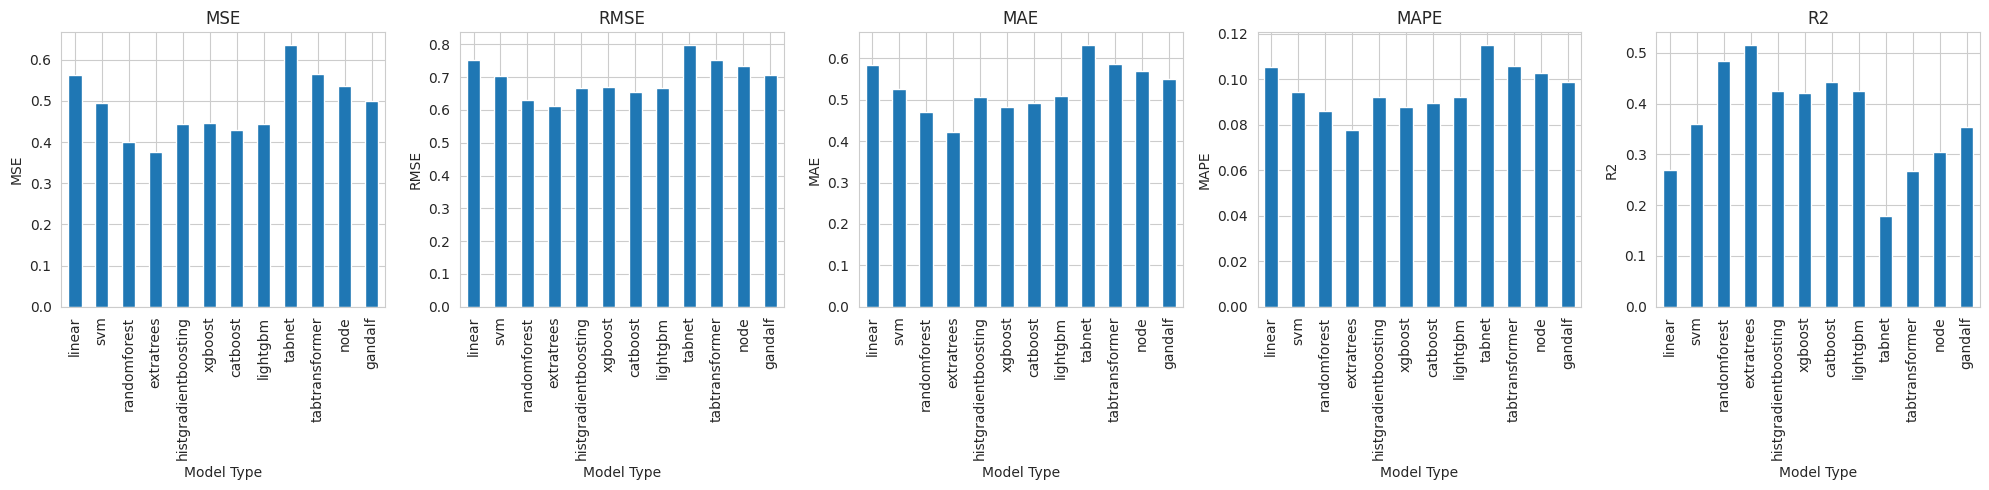

In [50]:
# Create plot of models' performances for each metric
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_df.columns), figsize=(20, 5))
for i, metric in enumerate(metrics_df.columns):
    metrics_df[metric].plot(kind='bar', ax=axes[i], title=metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model Type")

plt.tight_layout()
plt.show()